<div>
<img src="https://repository-images.githubusercontent.com/142679292/954e7180-2ef6-11ea-802d-5765d8448bd8" width="150" style="float: left;"/></div>

## sv1.9.2 (5 Nov 2020)
## Produce seasonal (un)calibrated forecasts and assess associated skill 


#### Requires: 
CPTv16.5.2+

#### Authors: 
Ángel G. Muñoz (agmunoz@iri.columbia.edu), Andrew W. Robertson (awr@iri.columbia.edu), Cuihua Li (OCP), Simon J. Mason (simon@iri.columbia.edu), Kyle Hall (IRI)

#### Acknowledgements: 
Rémi Cousin (IRI) for key Ingrid code development and support.
Xandre Chourio (IRI) for Windows and code support, and testing.
James Doss-Gollin (Columbia Water Center) developed the original download Python functions.
Part of the effort to develop PyCPT is funded by the Columbia World Project "Adapting Agriculture to Climate Today, for Tomorrow" (ACToday), and NOAA MAPP's projects NA18OAR4310275 (Muñoz) and NA16OAR4310145 (Robertson).

#### Version log
* This version now reads station data from the DL, and can run CPT in an automated way with it, but still doesn't have all plot functionality. --AGM 13 Sep 2019
* Started simplifying functions, wrote readGrADSctl function; added functions to create the NextGen files for det skill assessment and plotting --AGM, Sep 2019
* Fixed bug with plotting functions when selecting a subset of the seasons, and added start time for forecast file in CPT script -- AGM, July 1st 2019
* Added VQ and UQ from CFSv2. User can now select the seasons to visualize in the skill and EOF maps. Fixed bug related to coordinate selection in CHIRPS, TRMM and CPC. -- AGM, June 13th 2019
* First Notebook seasonal version -- AGM, May 7th 2019
* Several PyCPT sub-seasonal versions (through v1.2) --see logs in that version 2018-present
* First iPython sub-seasonal version (Jupyter Notebook) -- AWR, 24 Jun 2018
* First similar version (BASH for CFSv2) by Muñoz and Chourio for the OLE2 -- 12 Dec 2010 

#### Version log
See version.log in Github

#### Workflow
<div>
<img src="https://bitbucket.org/repo/X5dkaz8/images/133964354-image.png" width="700"/>
</div>

#### Input:
* Predictor is rainfall from S2S ECMWF (no realtime), or NCEP CFSv2 (realtime), or SubX GEFS (realtime)
* Predictand is either rainfall total or frequency of rainy days from TRMM (3B42 v7) or CPC Unified or IMD

#### Output:
* Several skill maps for assessment of deterministic forecast AND forecast maps, in the output folder.
* CPT scripts used to assess skill, in the scripts folder.
* Downloaded input files, in the input folder.

#### Notes:
1. Old data in the input folder is deleted at the beginning of the process!

### Namelist section

In [1]:
work='EPS-PRCP_abr-jun2023'
models=['EU-C3S-CMCC-SPS3p5']
obs='CHIRPS'
station=False
MOS='CCA'
PREDICTAND='PRCP'
pressure='850'  # UQ VQ: for desired horizontal moisture fluxes in the U (Zonal) and V (Meridional) directions at a geopotential height of P (user-definable: 700, 850, 925, etc.). 
PREDICTOR='UA'
init_month = 'Apr'
mons =[init_month]
#mons=['Dec']
tgtii=['1.5']  #S: start for the DL
tgtff=['3.5']   #S: end for the DL
#tgtii=['1.5','2.5']  #S: start for the DL
#tgtff=['1.5','2.5']   #S: end for the DL
#tgtii=['1.5','2.5']  #S: start for the DL
#tgtii='1.5'  #S: start for the DL
#tgtff='3.5'   #S: end for the DL
#for now, just write the target period (for DL)
tgts =['May-Jul'] #'Aug-Oct','Mar-May','Apr-Jun','May-Jul']   #Needs to be any of the seasons computed.
monss = tgts 
#tgts=['Jan','Feb']
#tgts =['Jan-Mar']
#Start and end of the training period: (must be >1982 for NMME models. Because of CanSIPSv2, probably end in 2018)
tini=1993
tend=2017


xmodes_min = 1
xmodes_max = 8
ymodes_min = 1
ymodes_max = 6
ccamodes_min = 1
ccamodes_max = 6


########Forecast date  
monf=init_month	# Initialization month 
fyr=2022	# Forecast year

########Switches:
force_download = True   #force download of data files, even if they already exist locally
single_models = True     #Switch Single_model plots on or off
forecast_anomaly=False # Switch to plot deterministic forecast anomaly maps.
forecast_spi = False # Switch to plot deterministic forecast precipitation maps as a standardized precipitation index (SPI). 
confidence_level=95 # Confidence level (%) for deterministic forecast confidence interval (-/+ confidence_level) maps.

# Want to add a topo background to the domain plots?
use_topo=True
map_color='WindowsCPT' #set to "WindowsCPT" for CPT colorscheme
colorbar_option=True
use_ocean=False

In [2]:
########Some folder and file options:
# Working directory --it should exist!!!
########Predictor (choose between GCM's P
#workdir = '/mnt/c/Users/Patri/OneDrive/Columbia_Academics/S2S4/iri-pycpt/'
#workdir = '/Users/kjhall/Projects/iri-pycpt/'
#workdir = '/home/cli/iri-pycpt23-git/'
workdir = '~/DEV/EPS/iri-pycpt/'
savedir = workdir  # location in which the current .ipynb is located, for saving Jupyter notebooks
# PATH to CPT root directory
#cptdir='/mnt/c/Users/Patri/Downloads/CPT/16.5.8/'
#cptdir='/Users/kjhall/CPT/16.5.8/'
cptdir='/home/guillermo/DEV/EPS/CPT/17.7.4/'
#workdir = '/home/cli/iri-pycpt3-git/'
# PATH to CPT root direcldatetory
#cptdir='/Users/agmunoz/Documents/Angel/CPT/CPT/16.2.4/'
#cptdir='/software/centos7/x86_64/CPT/ldate16.5.4/bin/'

print("PyCPT folder is:")
%cd $workdir
!mkdir -p $work

PyCPT folder is:
/home/guillermo/DEV/EPS/iri-pycpt


### End of namelist section  (do not modify anything below this line)

#### Load Libraries

In [3]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import subprocess
from pycpt_functions_seasonal import *
from pycpt_dictionary import dic_sea, dic_sea_elr
from scipy.stats import t
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import calendar
print("Python libraries loaded")
print("Now in the work folder:")
%cd $work
workdir = os.getcwd()
(rainfall_frequency,threshold_pctle,wetday_threshold,obs_source,hdate_last,mpref,L,ntrain,fprefix, x_offset, y_offset)=setup_params(PREDICTOR,PREDICTAND,obs,MOS,tini,tend)

Python libraries loaded
Now in the work folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023
Predictand is Rainfall Total (mm)


In [4]:
print("Creating working folders, if not already there...")
print("Work directory is:")
%cd $workdir
!mkdir -p input
!mkdir -p input/noMOS
!mkdir -p output
!mkdir -p scripts
!rm -Rf scripts/*
!mkdir -p output/figures

# Set up CPT environment
os.environ["CPT_BIN_DIR"] = cptdir
print("CPT environment loaded... "+cptdir)
#print("CPT version is "+str(wetday_threshold))

Creating working folders, if not already there...
Work directory is:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023
CPT environment loaded... /home/guillermo/DEV/EPS/CPT/17.7.4/


## Check if domains are ok --if you don't like them, go back to the namelist and modify them

In [5]:
#14.209009,-92.810319
#18.300294,-87.423619
# ########Spatial domain for predictor
nla1=19	# Northernmost latitude
sla1=13 	# Southernmost latitude
wlo1=-93 	# Westernmost longitude
elo1=-87 	# Easternmost longitude
# Spatial domain for predictand
nla2=19 	# Northernmost latitude
sla2=13 	# Southernmost latitude
wlo2=-93 	# Westernmost longitude
elo2=-87 	# Easternmost longitude

In [6]:
nla1=40	# Northernmost latitude
sla1=-5 	# Southernmost latitude
wlo1=-120 	# Westernmost longitude
elo1=-70 	# Easternmost longitude
# Spatial domain for predictand
nla2=40 	# Northernmost latitude
sla2=-5 	# Southernmost latitude
wlo2=-120 	# Westernmost longitude
elo2=-70 	# Easternmost longitude

Training period: 1993-2017
Forecast initialized on: Apr 2022


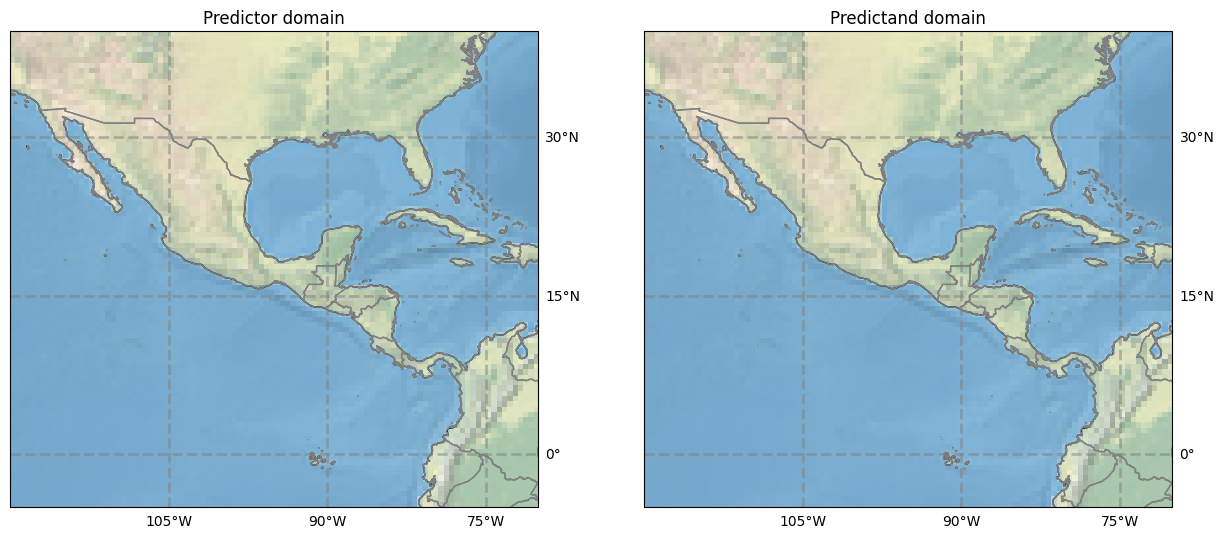

In [7]:
print("Training period: "+str(tini)+"-"+str(tend))
print("Forecast initialized on: "+monf+" "+str(fyr))

#Plot geographical domains
pltdomain(wlo1,elo1,nla1,sla1,wlo2,elo2,nla2,sla2,use_topo)

# Download data if necessary, and run CPT

In [8]:
force_download=True

In [9]:
workdir + "/scripts"

'/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023/scripts'

In [10]:
#If downloadling data from several models, this section might take a while to be done
for model in models:
    print('')
    print('')
    print('\033[1m----Starting process for '+model+'----\033[0;0m')
    for mo in range(len(mons)):
        mon=mons[mo]
        tar=tgts[mo]
        tgti=tgtii[mo]
        tgtf=tgtff[mo]
        print("New folder:")
        %cd $workdir/input

        print('Preparing CPT files for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m...')        
        PrepFiles(fprefix, PREDICTAND, threshold_pctle, tini, tend, wlo1, wlo2,elo1, elo2, sla1, sla2, nla1, nla2, tgti, tgtf, mon, monf, fyr, os, wetday_threshold, tar, model, obs, obs_source, hdate_last, force_download, station, dic_sea, dic_sea_elr, pressure, MOS)
        print("New folder:")
        %cd $workdir/scripts

        CPTscript(model,PREDICTAND, mon,monf, fyr, tini,tend,nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,MOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, forecast_anomaly, forecast_spi)

        print('Executing CPT for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m...')
        try:
            subprocess.check_output(cptdir+'CPT.x < params > CPT_log_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
        except subprocess.CalledProcessError as e:
            print(e.output.decode())
            raise
        print('----------------------------------------------')
        print('Calculations for Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m completed!')

        print('See output folder, and check scripts/CPT_log_'+model+'_'+tar+'_'+mon+'.txt for log')
        print('\033[1mQuick error report from CPT (if any):\033[0;0m')
        with open('CPT_log_'+model+'_'+tar+'_'+mon+'.txt', "r") as fp:
            for line in lines_that_contain("Error:", fp):
                print (line)
        print('----------------------------------------------')
        print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')



----Starting process for EU-C3S-CMCC-SPS3p5----
New folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023/input
Preparing CPT files for EU-C3S-CMCC-SPS3p5. Target: May-Jul - Initialization Apr...

 Hindcasts URL: 

 http://iridl.ldeo.columbia.edu/SOURCES/.EU/.Copernicus/.CDS/.C3S/.CMCC/.SPSv3p5/.hindcast/.ua/P/850/VALUE/S/%281%20Apr%201993-2017%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/%5BM%5Daverage/Y/-5/40/RANGEEDGES/X/-120/-70/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BL/S/add/%5D/cptv10.tsv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  756k    0  756k    0     0  17768      0 --:--:--  0:00:43 --:--:-- 20329--:-- --:--:--     0     0  23738      0 --:--:--  0:00:10 --:--:-- 13196
Hindcasts file ready to go
----------------------------------------------

 Obs (Rainfall) data URL: 

 https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2

## EOF Analysis (only available if MOS=PCR or CCA)
Note: we are repeating the plots of the observed field EOFs & PCs (ie Y) alongside the GCMs ones for convenient reference

Present folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023/output




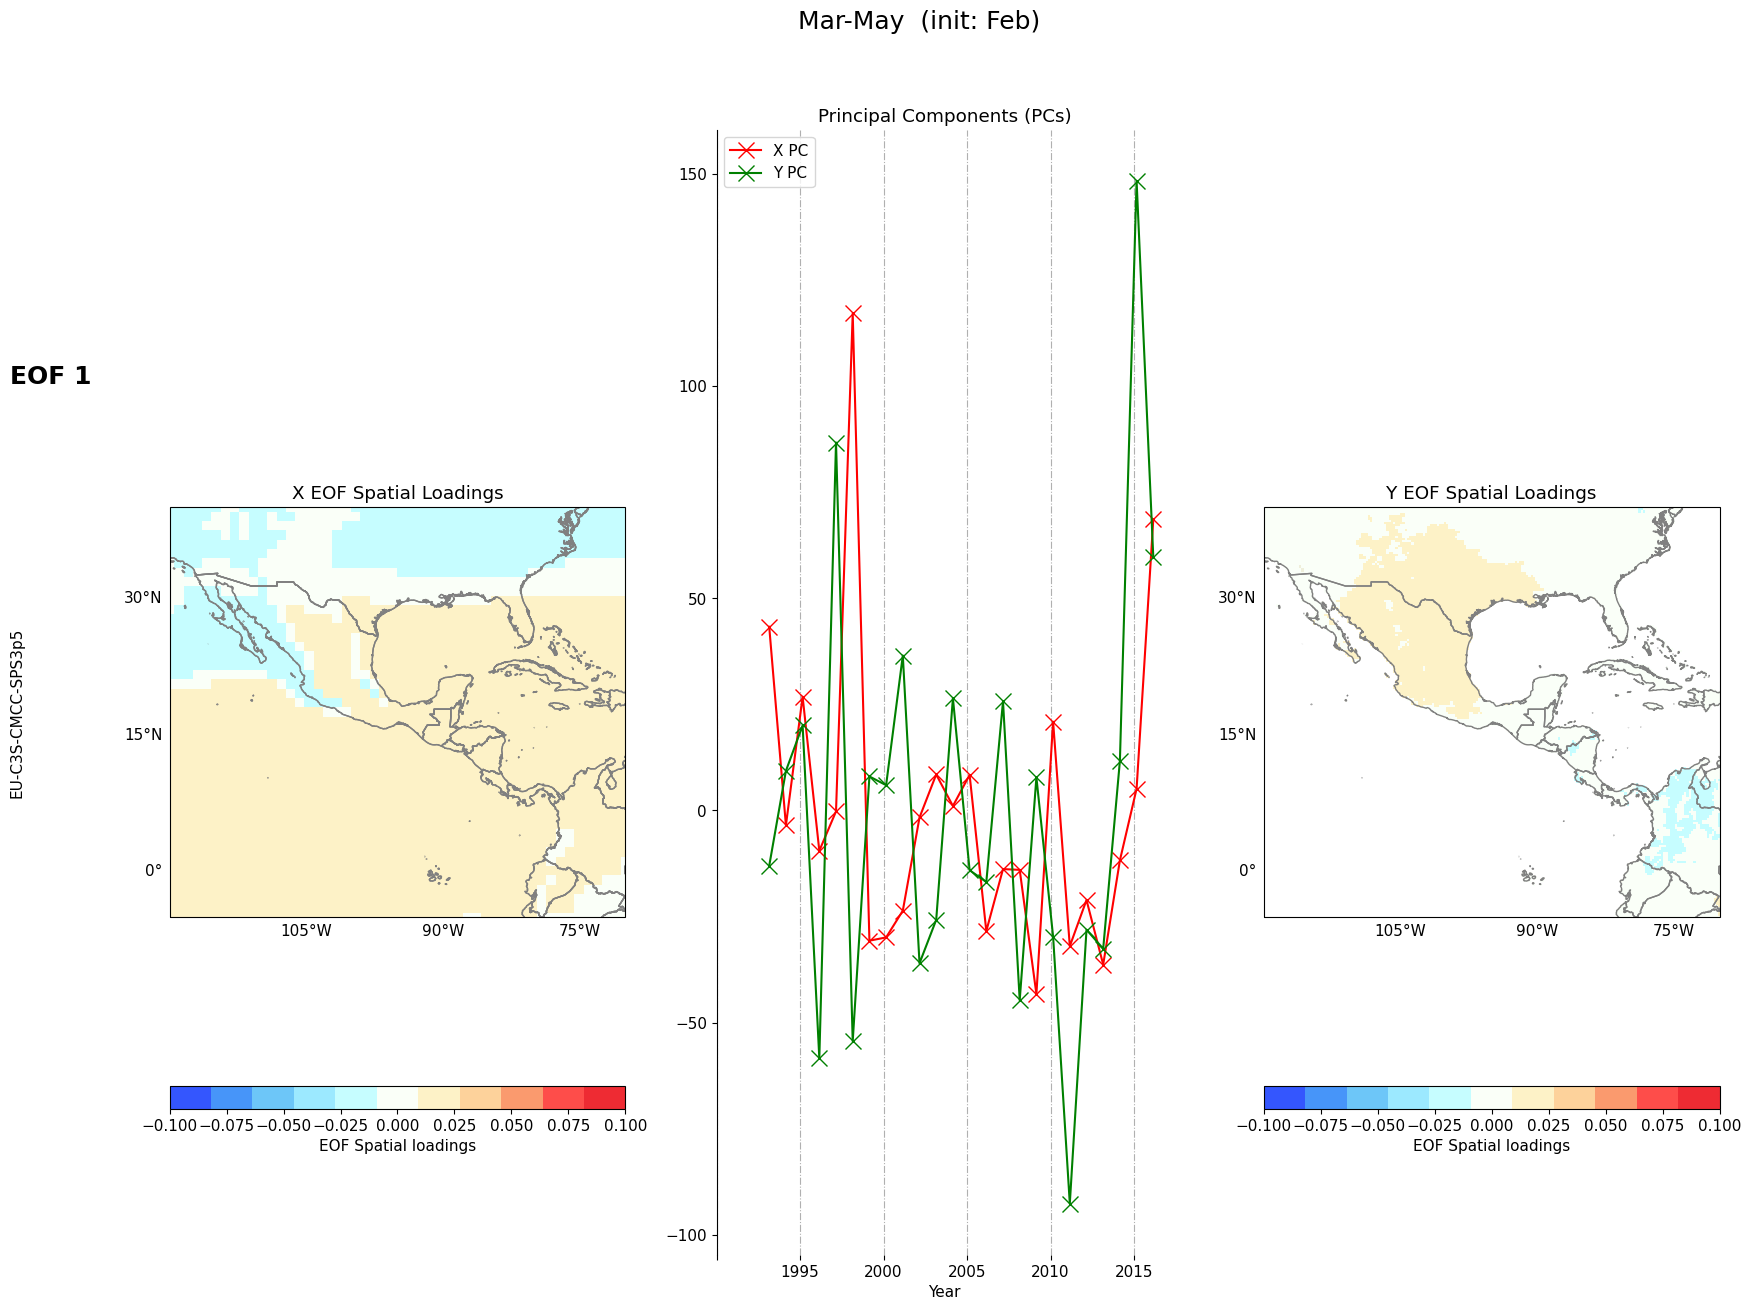

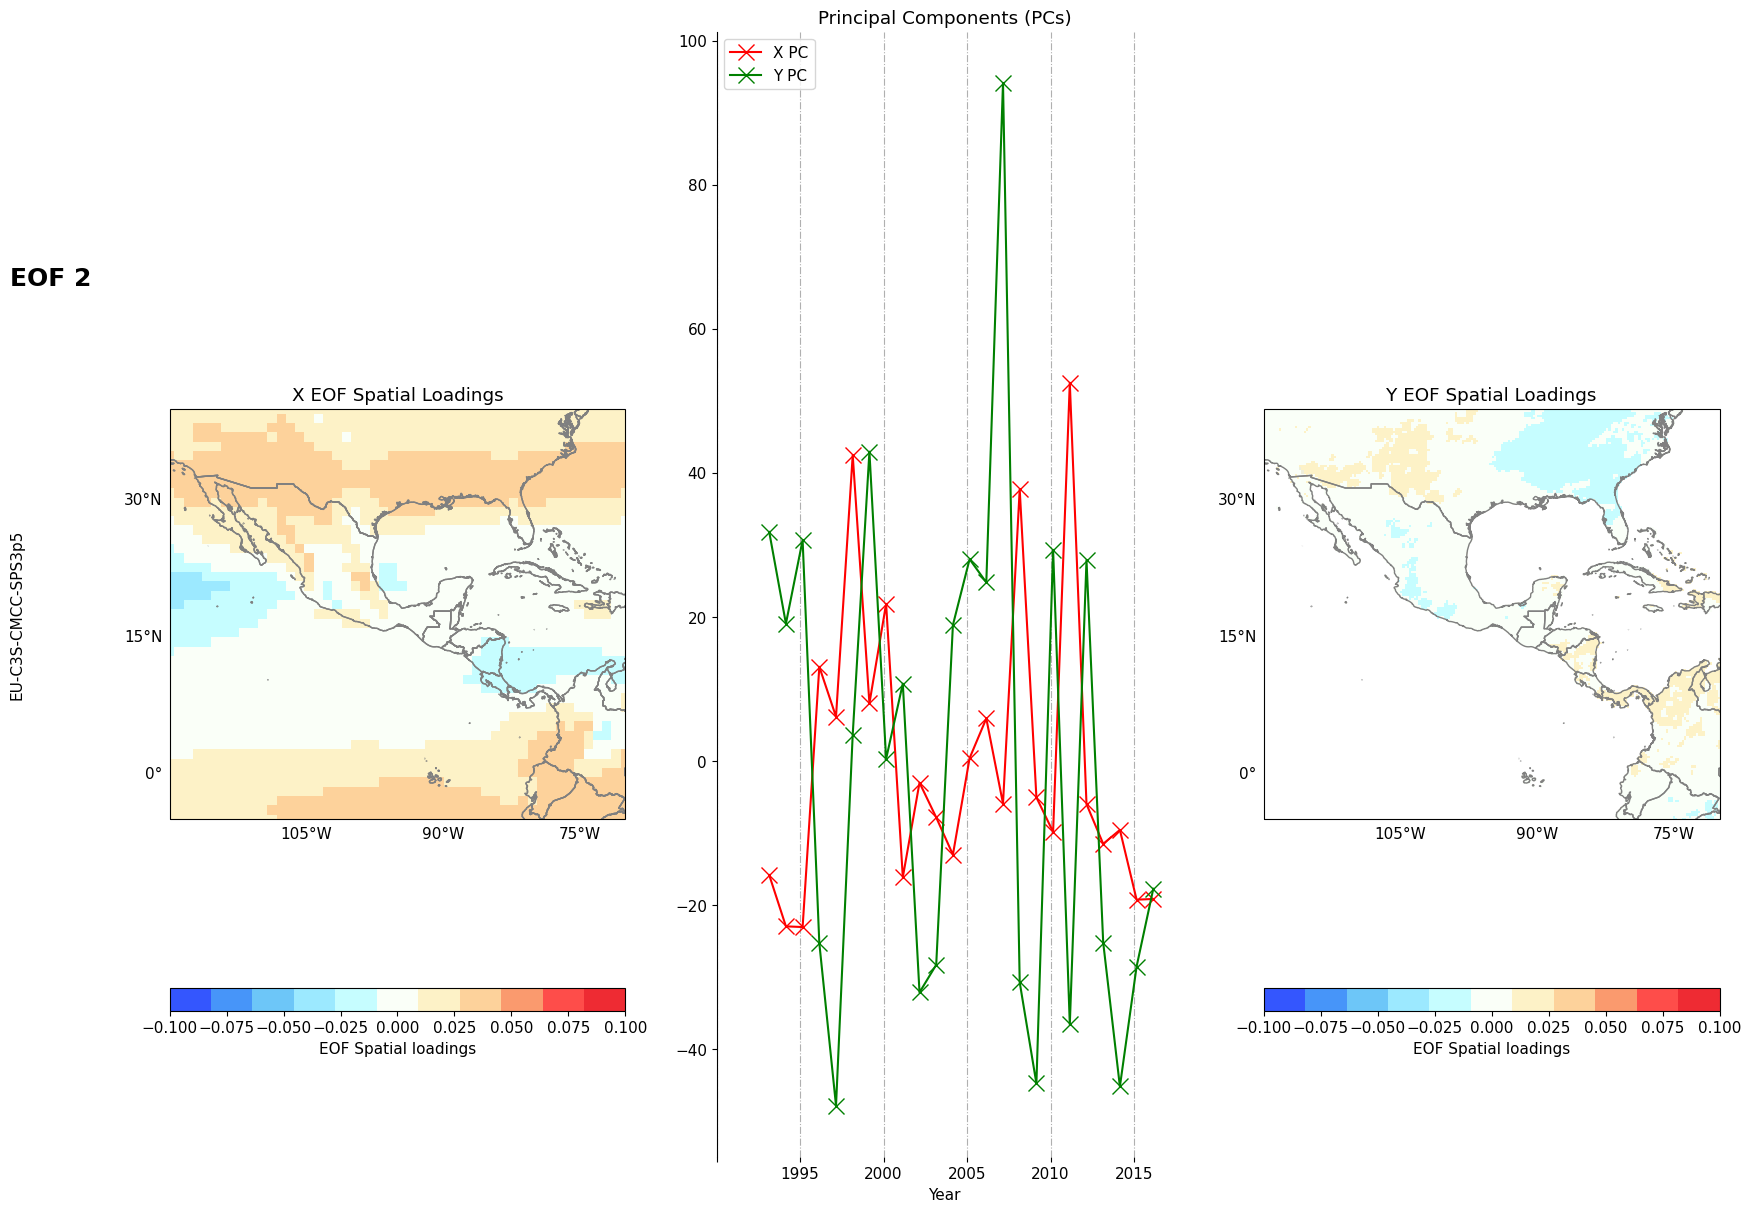

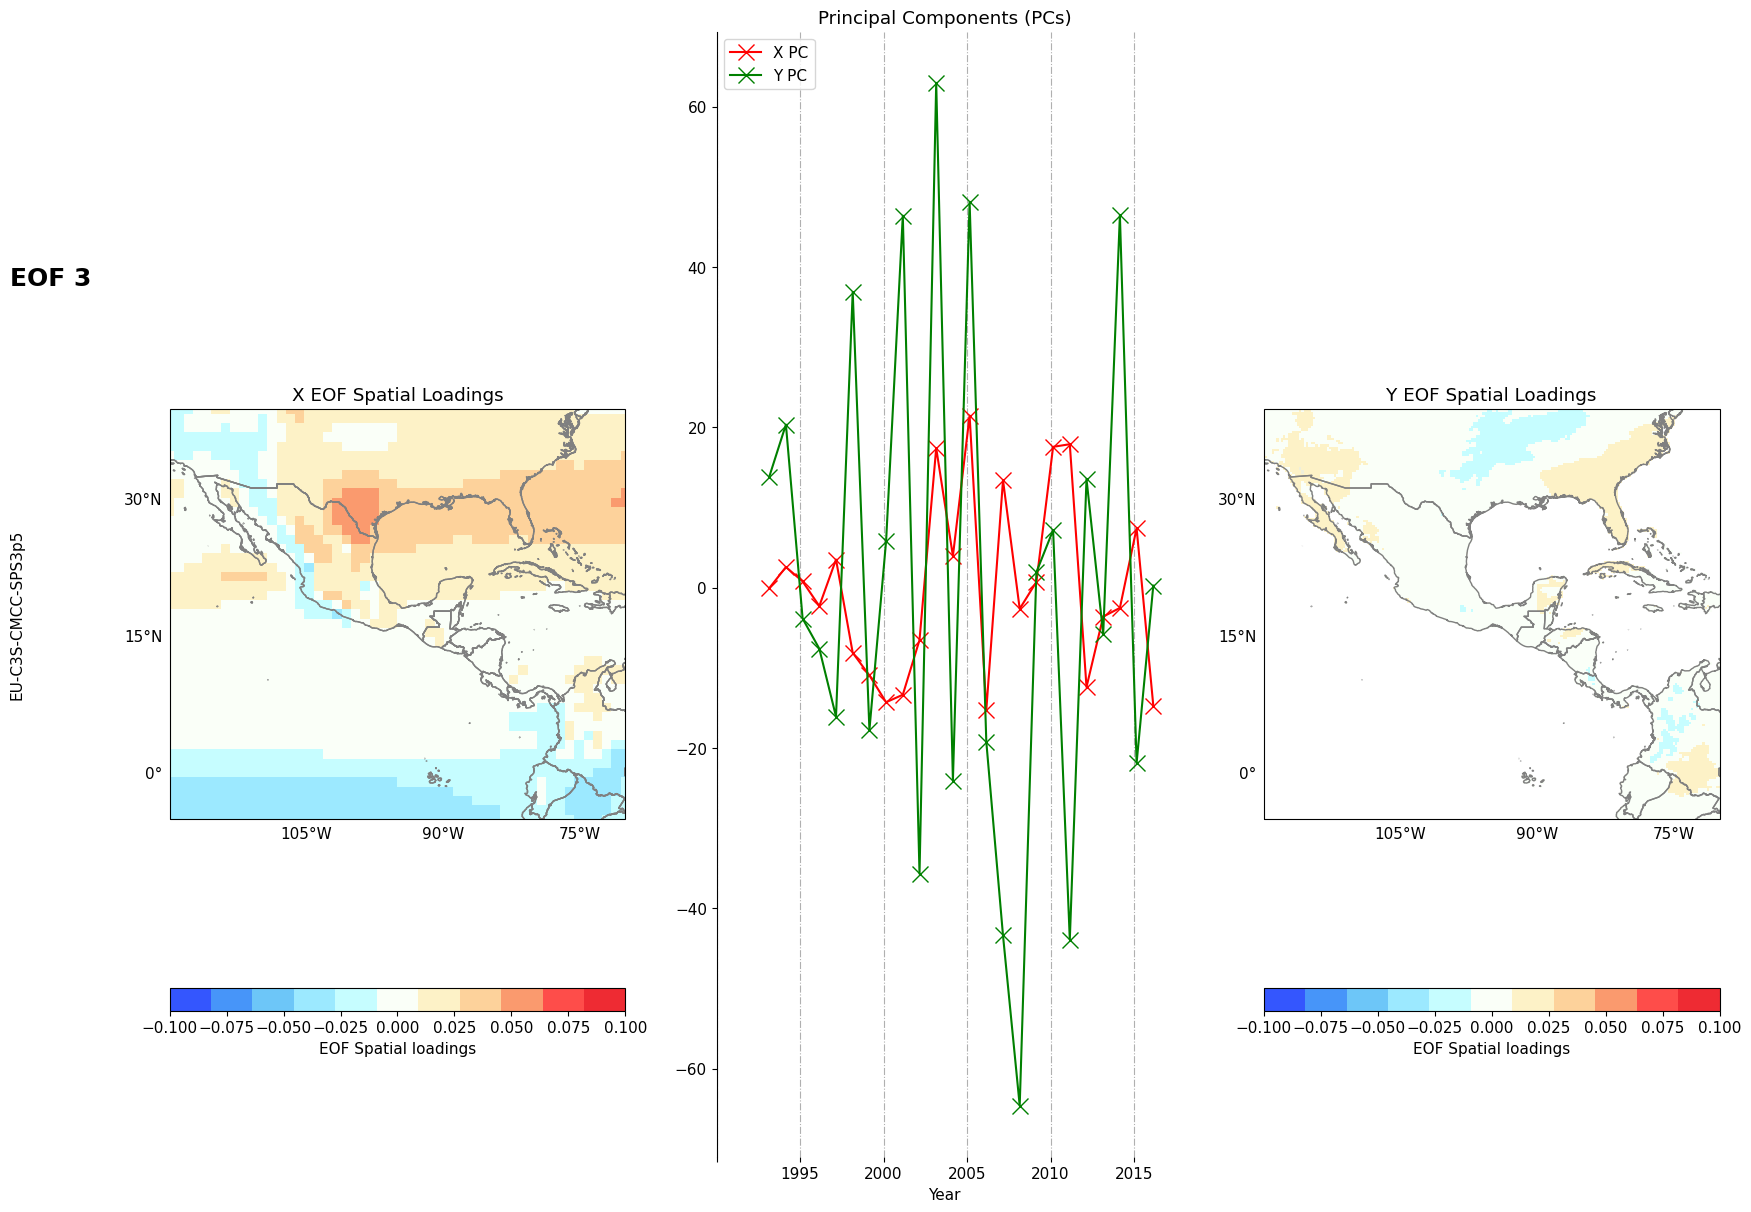

In [57]:
#monss=['Jul-Sep']#'Aug-Oct','Mar-May','Apr-Jun','May-Jul']   #Needs to be any of the seasons computed.
neofs_plot = 3

print("Present folder:")
%cd $workdir/output
print('')
print('')

if MOS=='None':
    print("To compute EOFs you need to choose MOS=PCR or MOS=CCA")
else:
    # EOF loop
    plt.rcParams.update({'font.size': 11})
    for imod in range(neofs_plot):
        plteofs_eofts(models,PREDICTOR,PREDICTAND,imod,neofs_plot,wlo1,elo1,sla1,nla1,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss,map_color, colorbar_option, use_ocean, x_offset=x_offset, y_offset=y_offset)
        plt.show()

## CCA Spatial Loadings and Time Series (only available if MOS=CCA)
Author: Cuihua / Patric / Kyle 

Present folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023/output




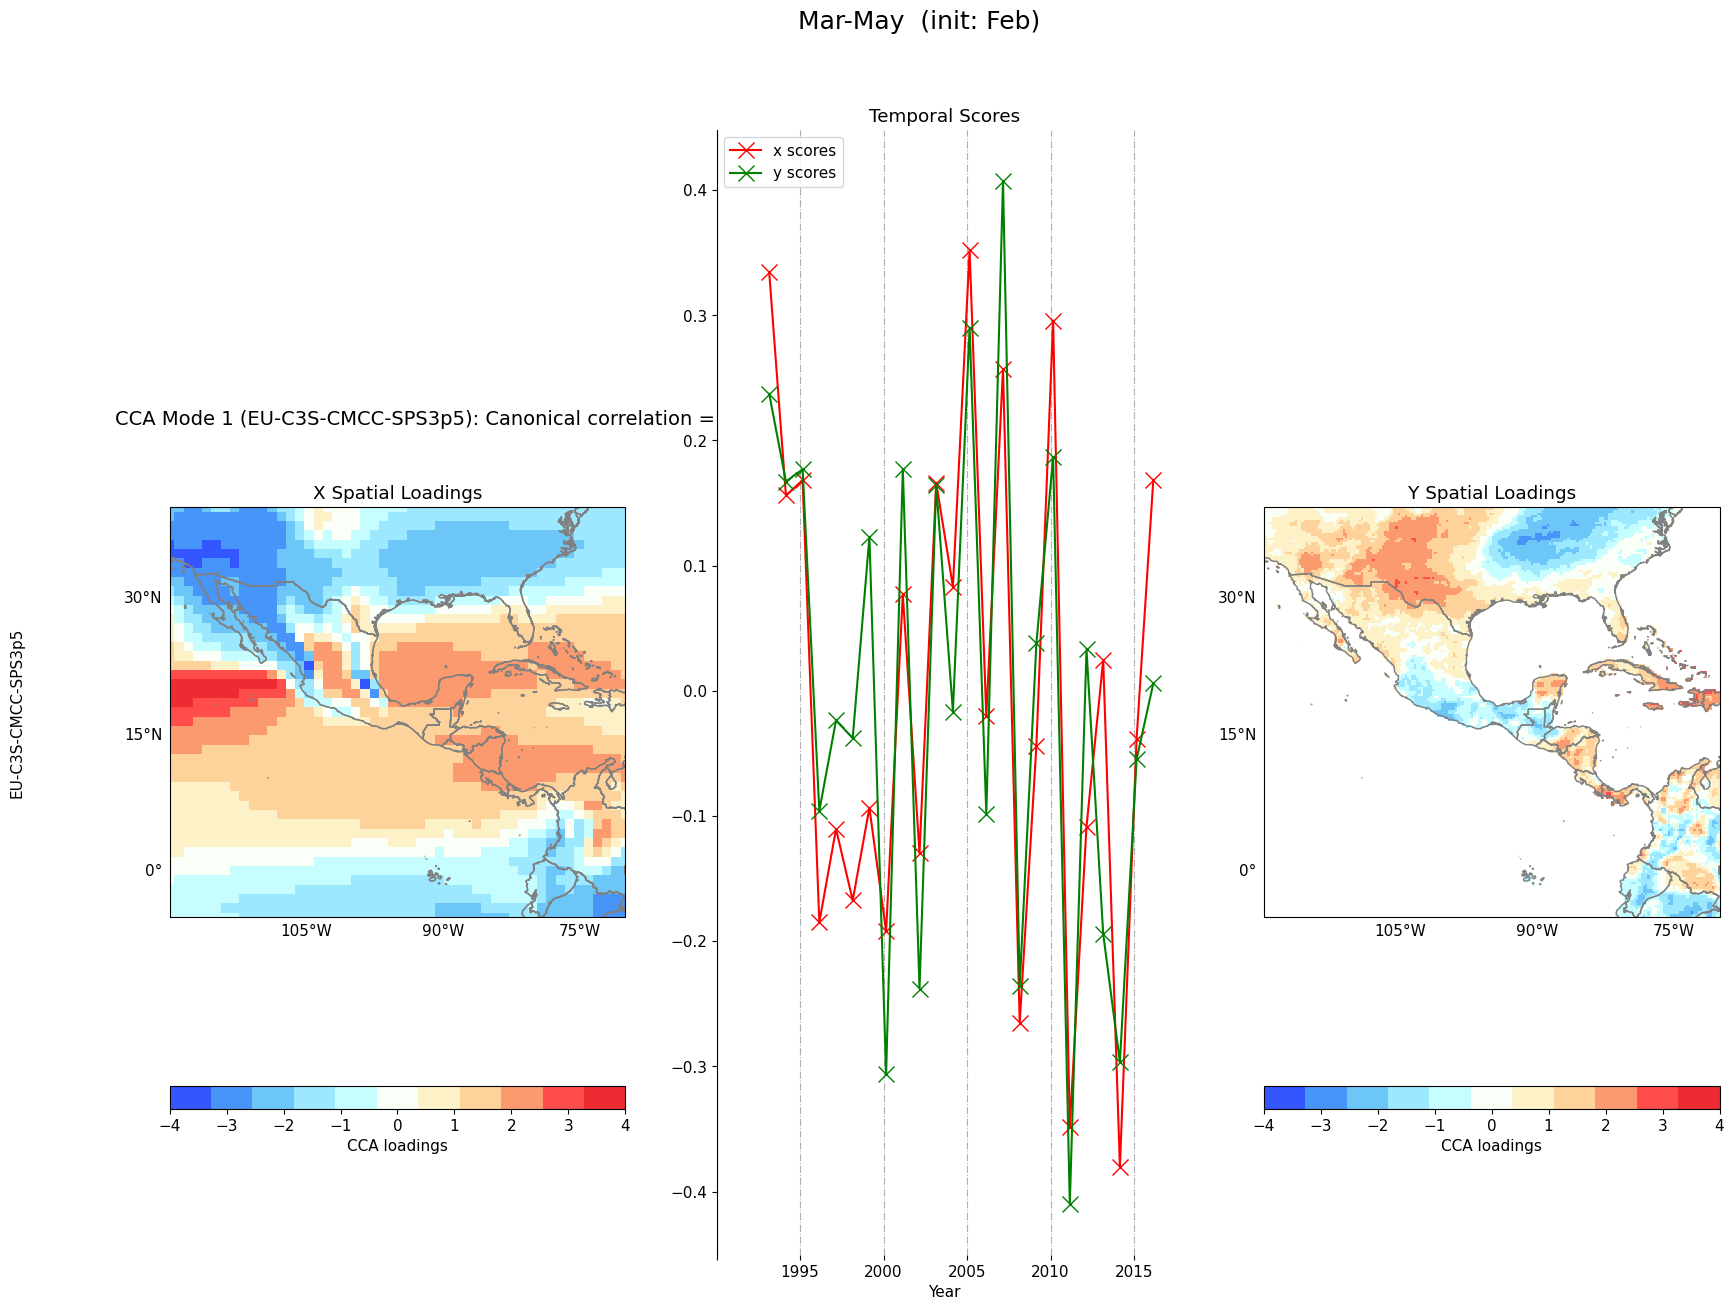

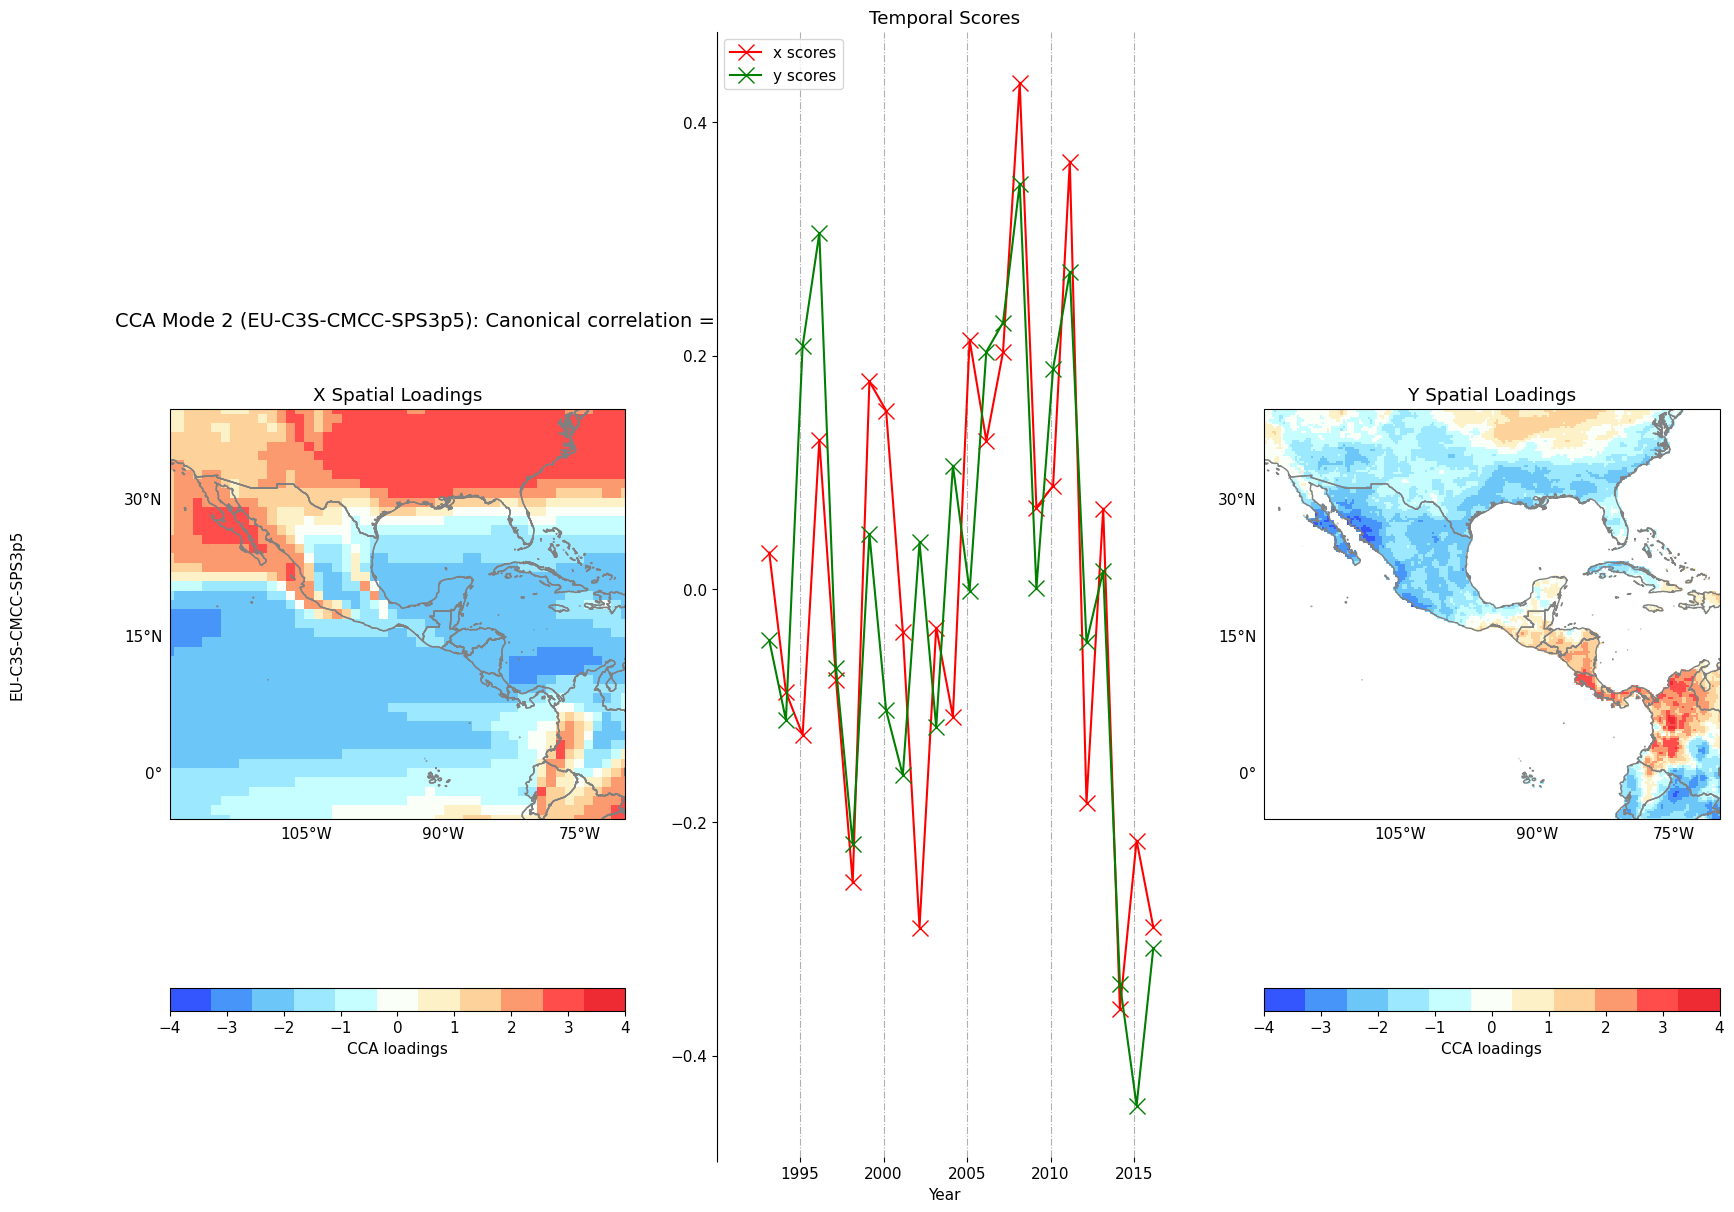

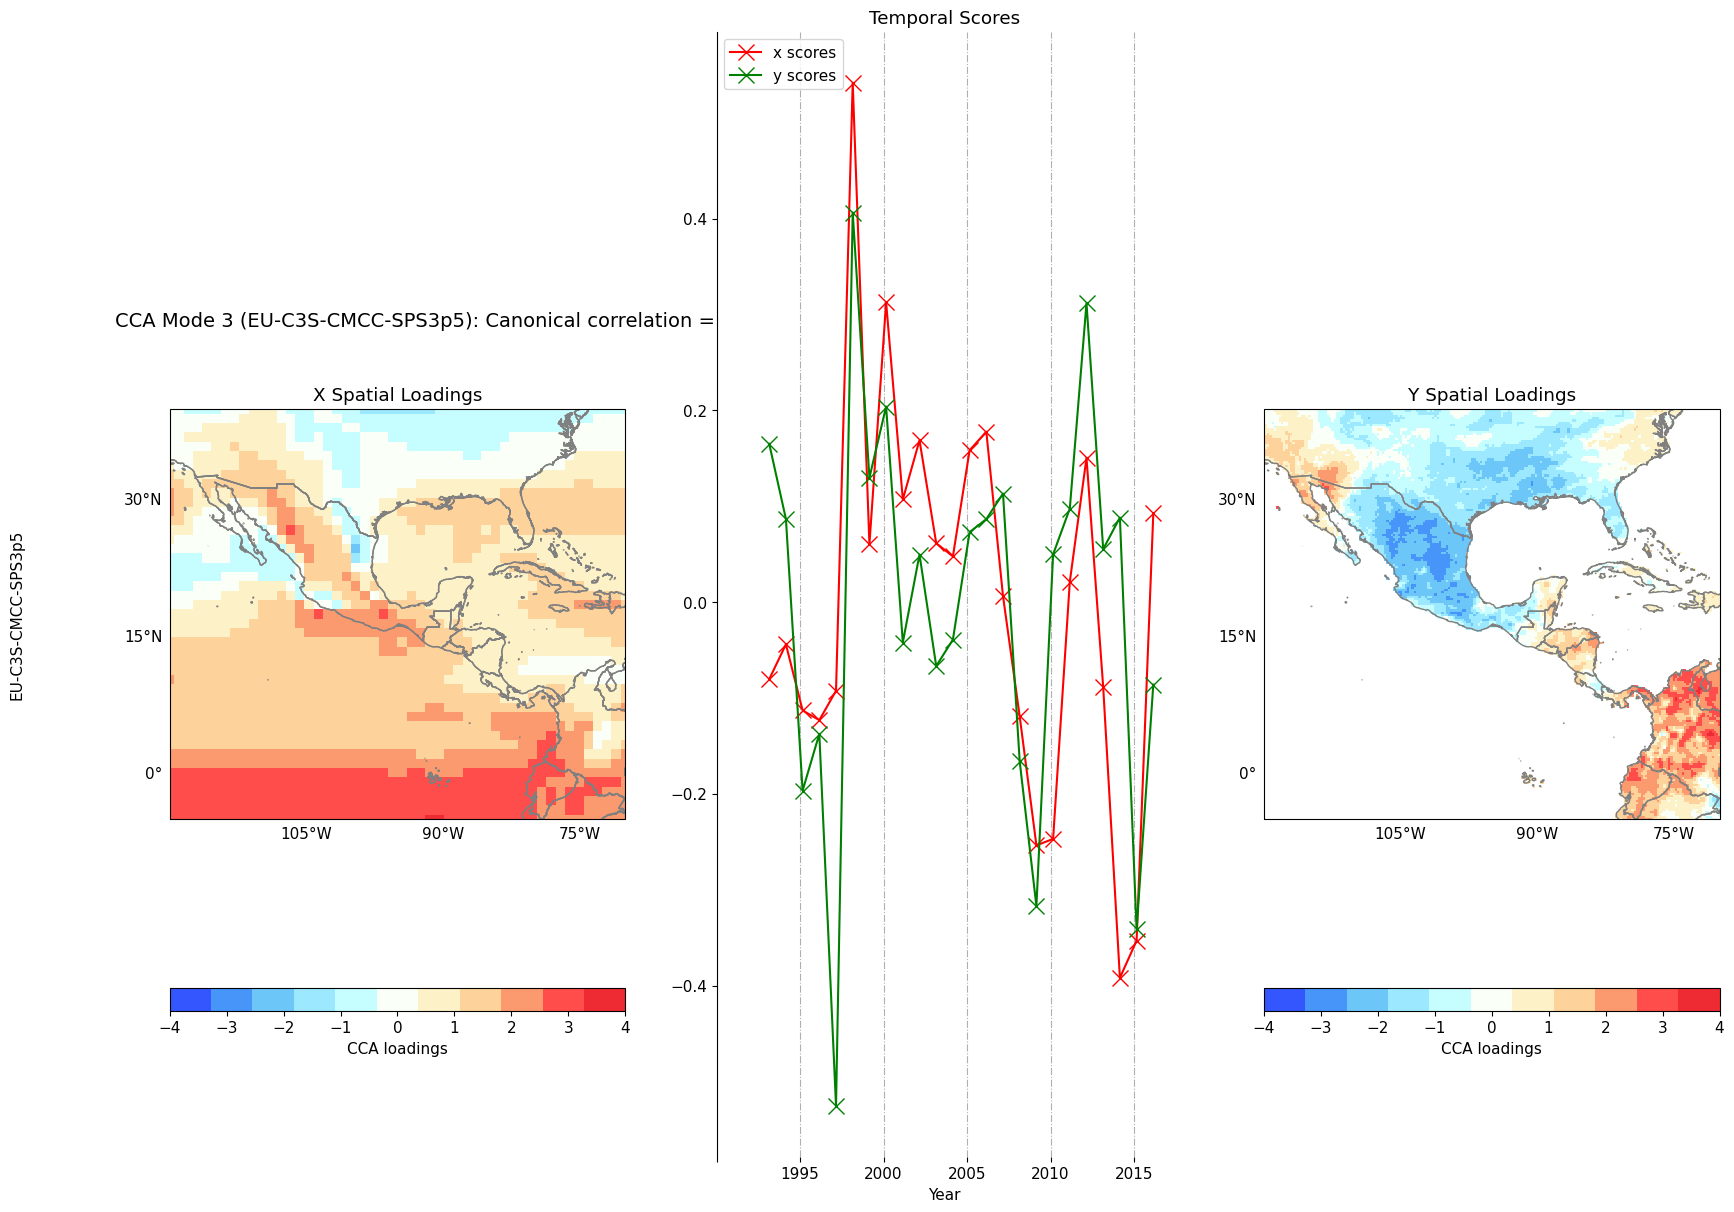

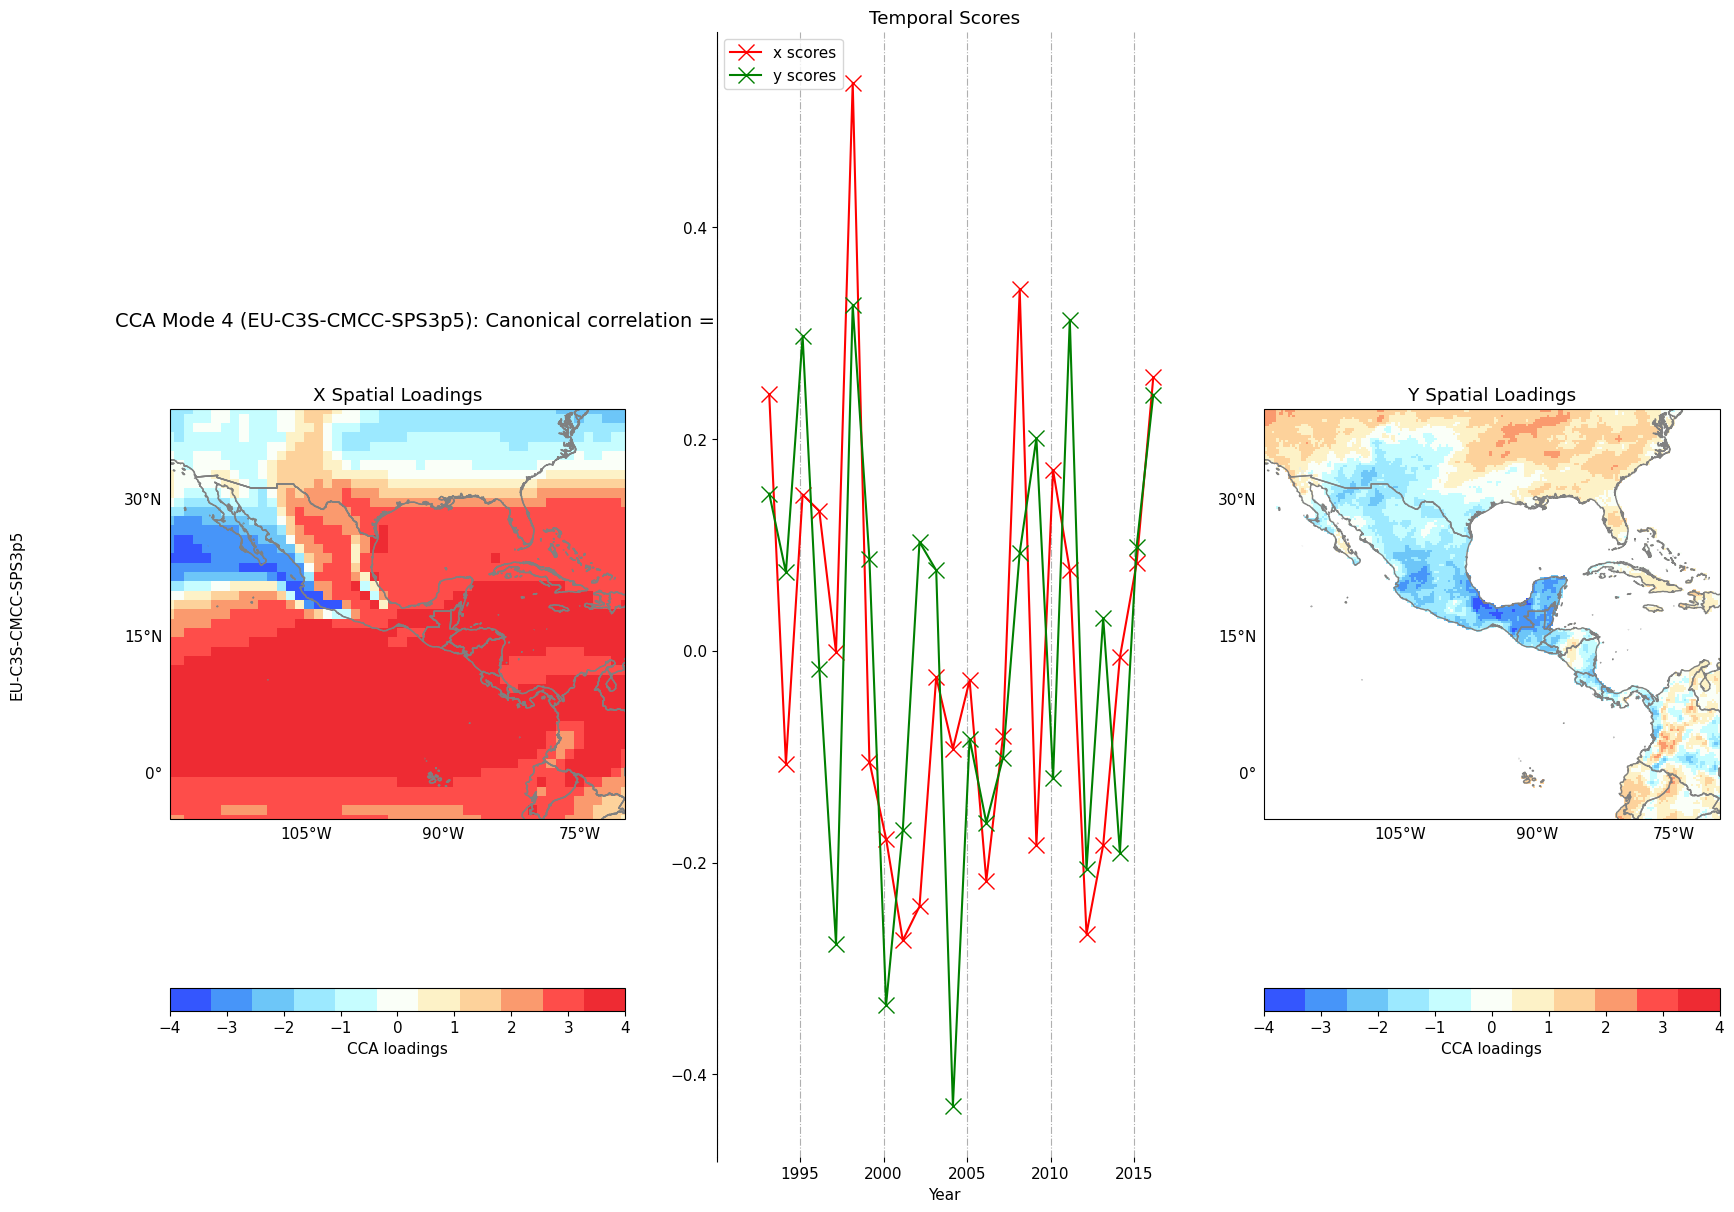

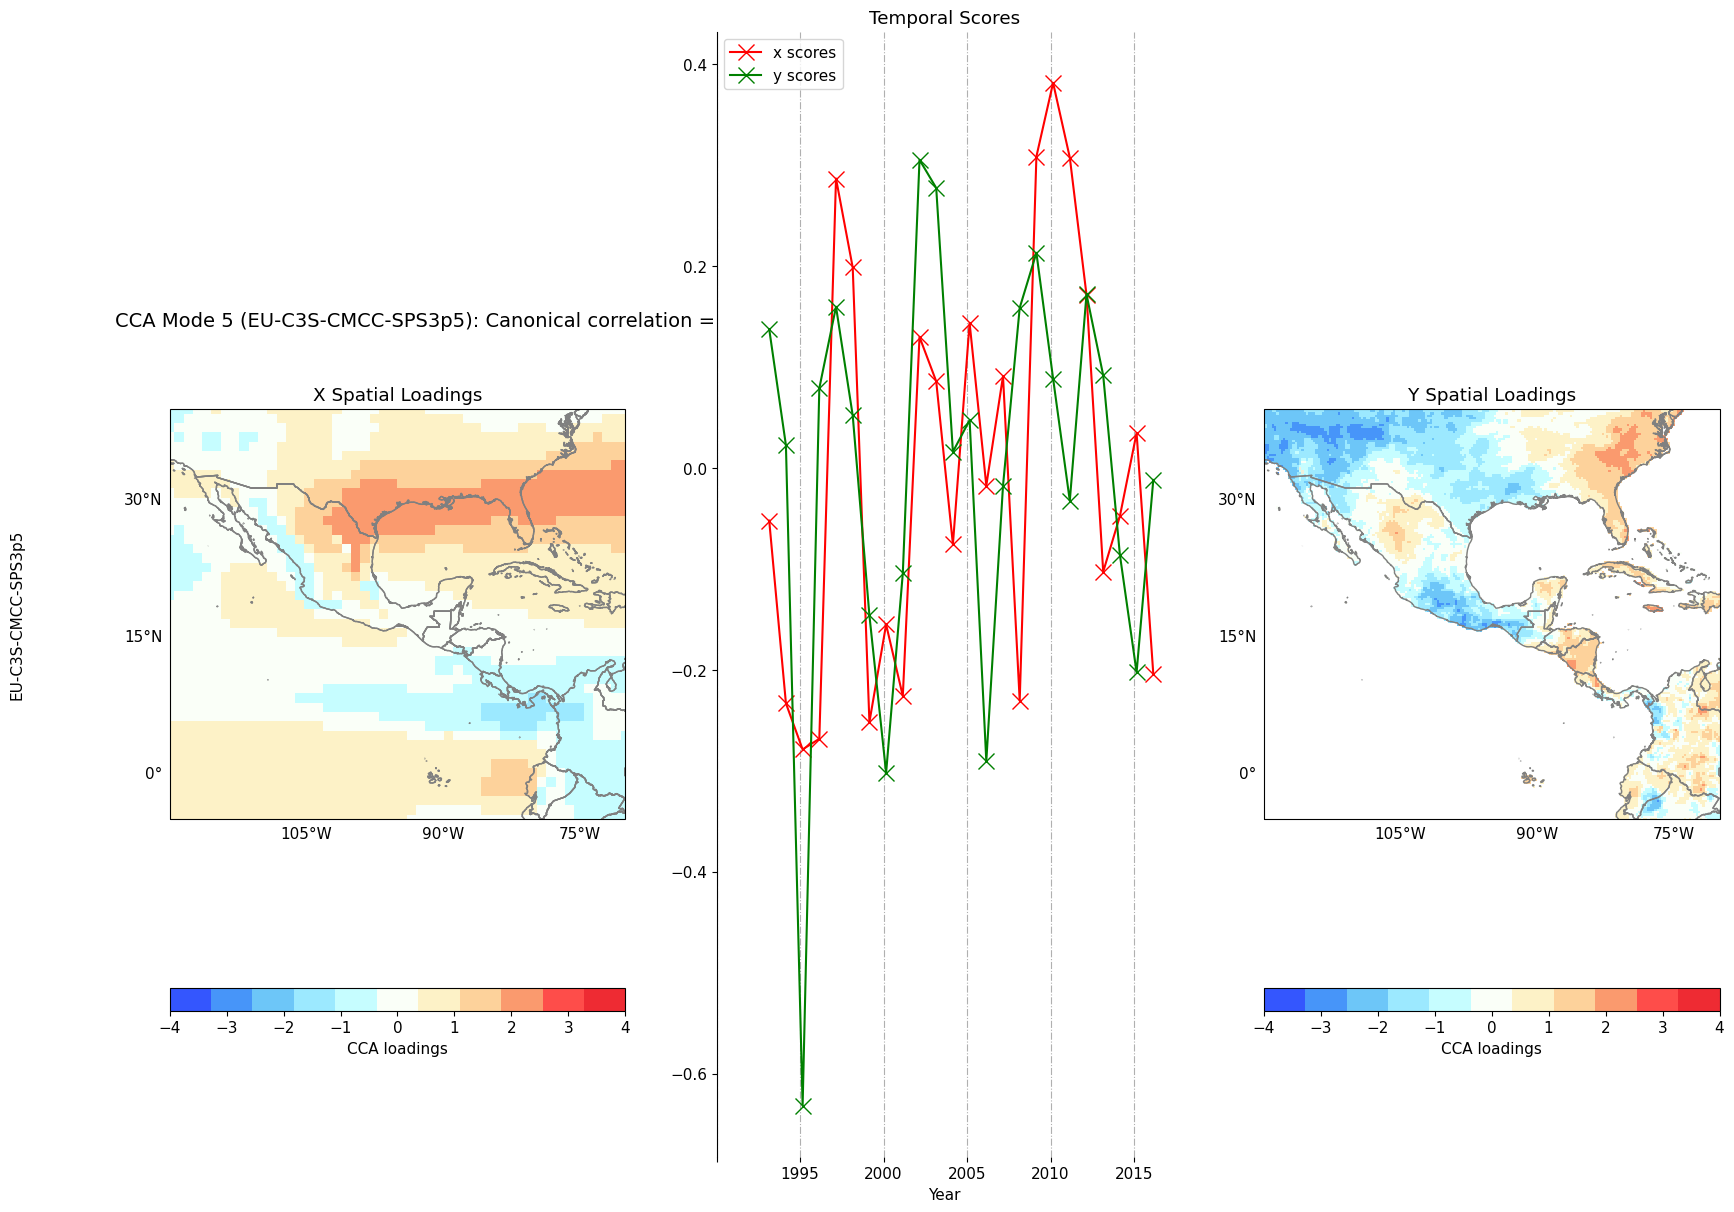

In [58]:
#monss=['Jul-Sep']#'Aug-Oct','Mar-May','Apr-Jun','May-Jul']   #Needs to be any of the seasons computed.

print("Present folder:")
%cd $workdir/output
print('')
print('')

if MOS!='CCA':
    print("To compute CCAs you need to choose MOS=CCA")
else:
    # CCA loop
    plt.rcParams.update({'font.size': 11})
    pltccas_ccats(models,PREDICTOR,PREDICTAND,wlo1,elo1,sla1,nla1,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss,map_color, colorbar_option, use_ocean, x_offset=x_offset, y_offset=y_offset)
    plt.show()

## Skill Analysis

In [62]:
models

['EU-C3S-CMCC-SPS3p5']

Present folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023/output

Pearson


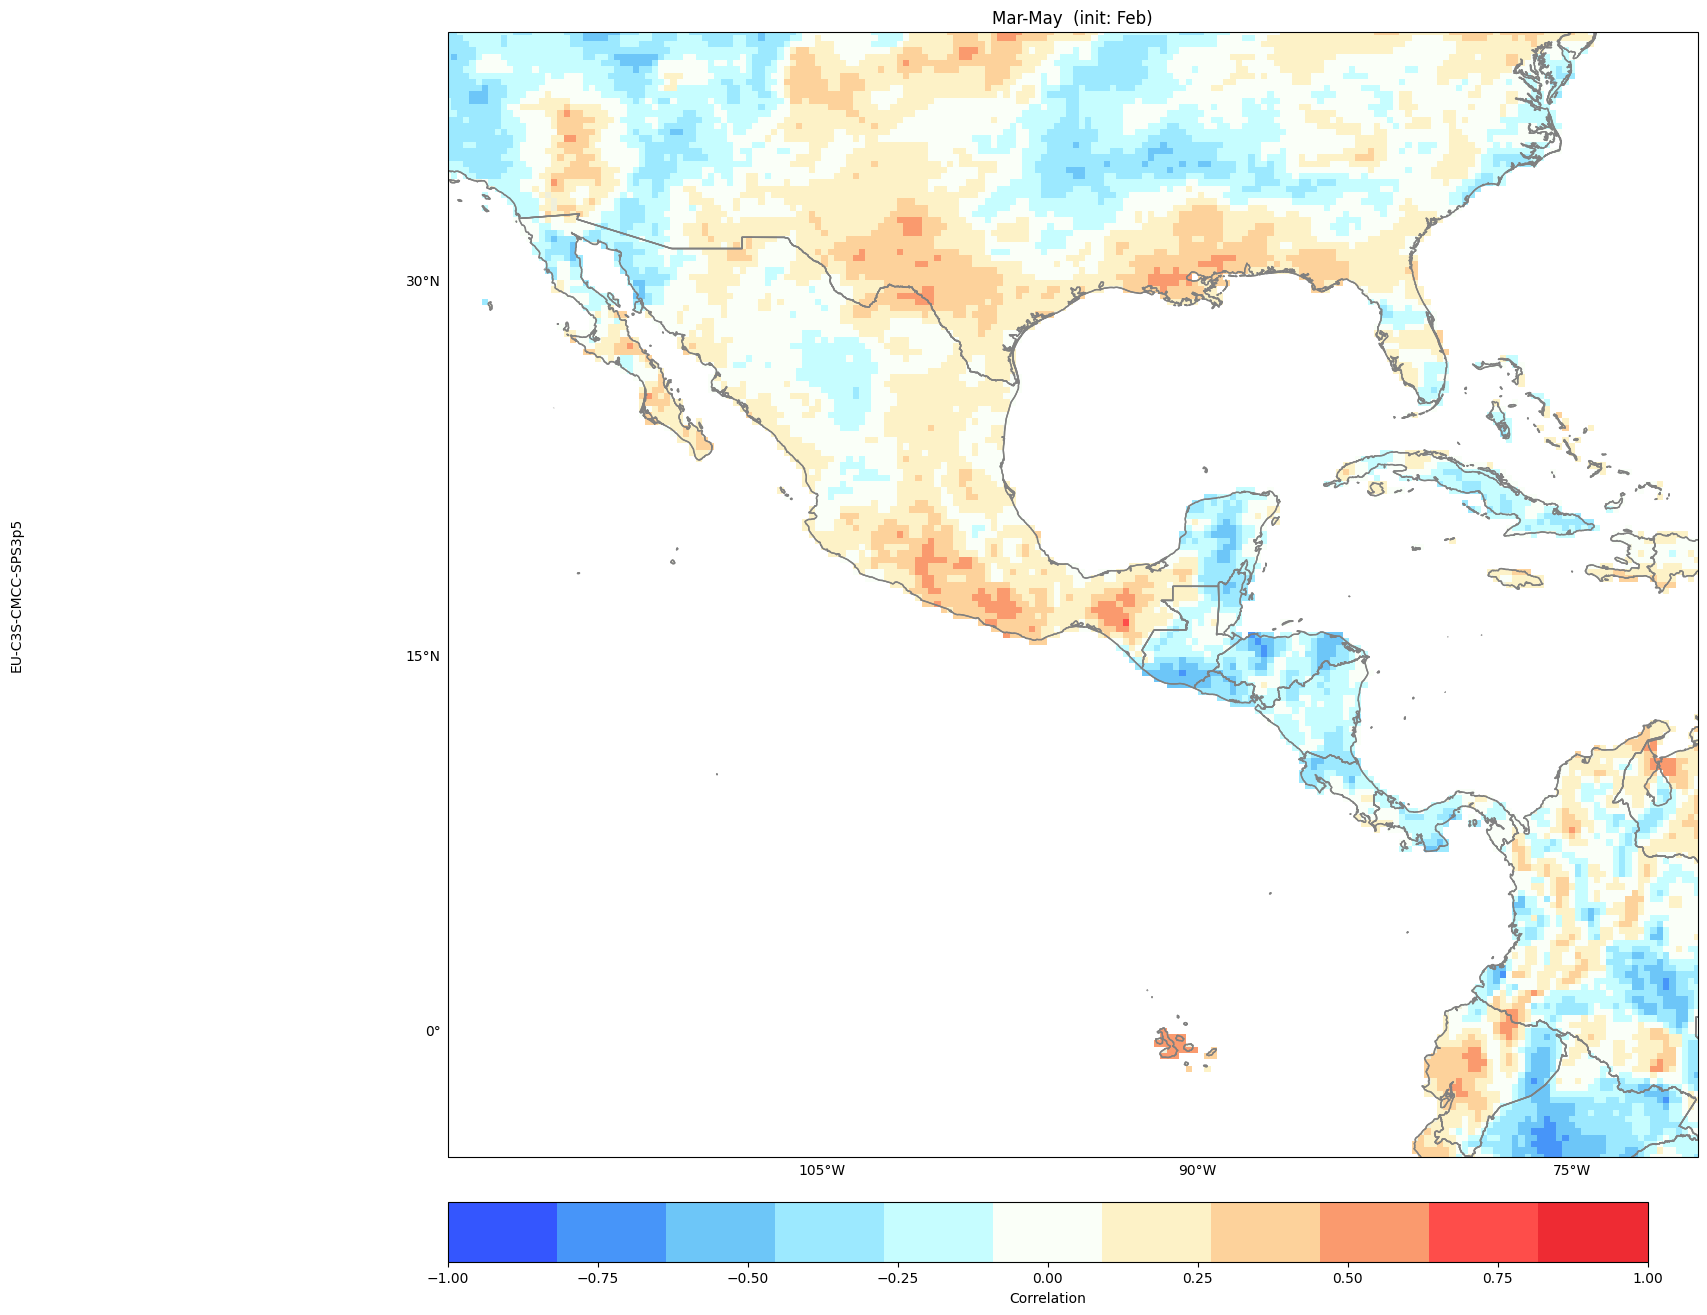



Spearman


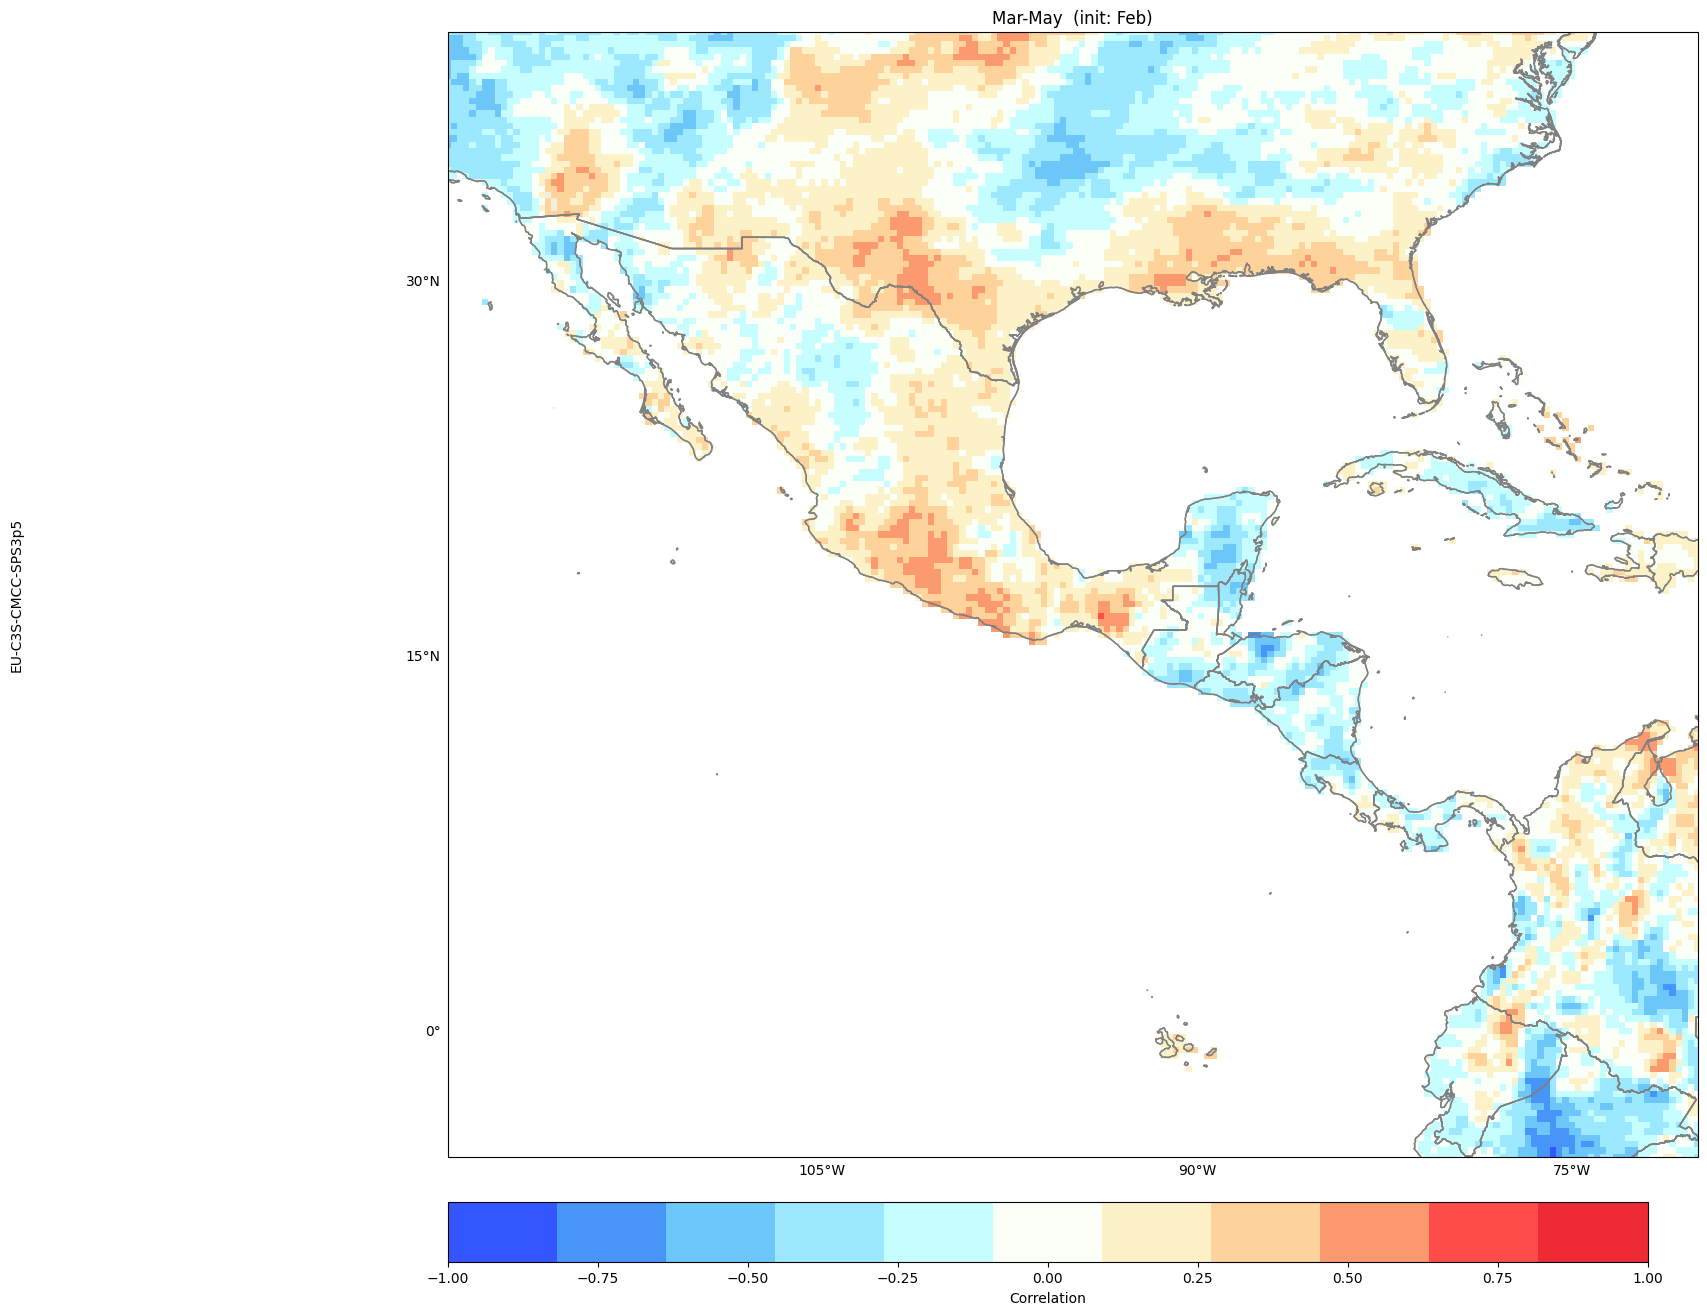



2AFC


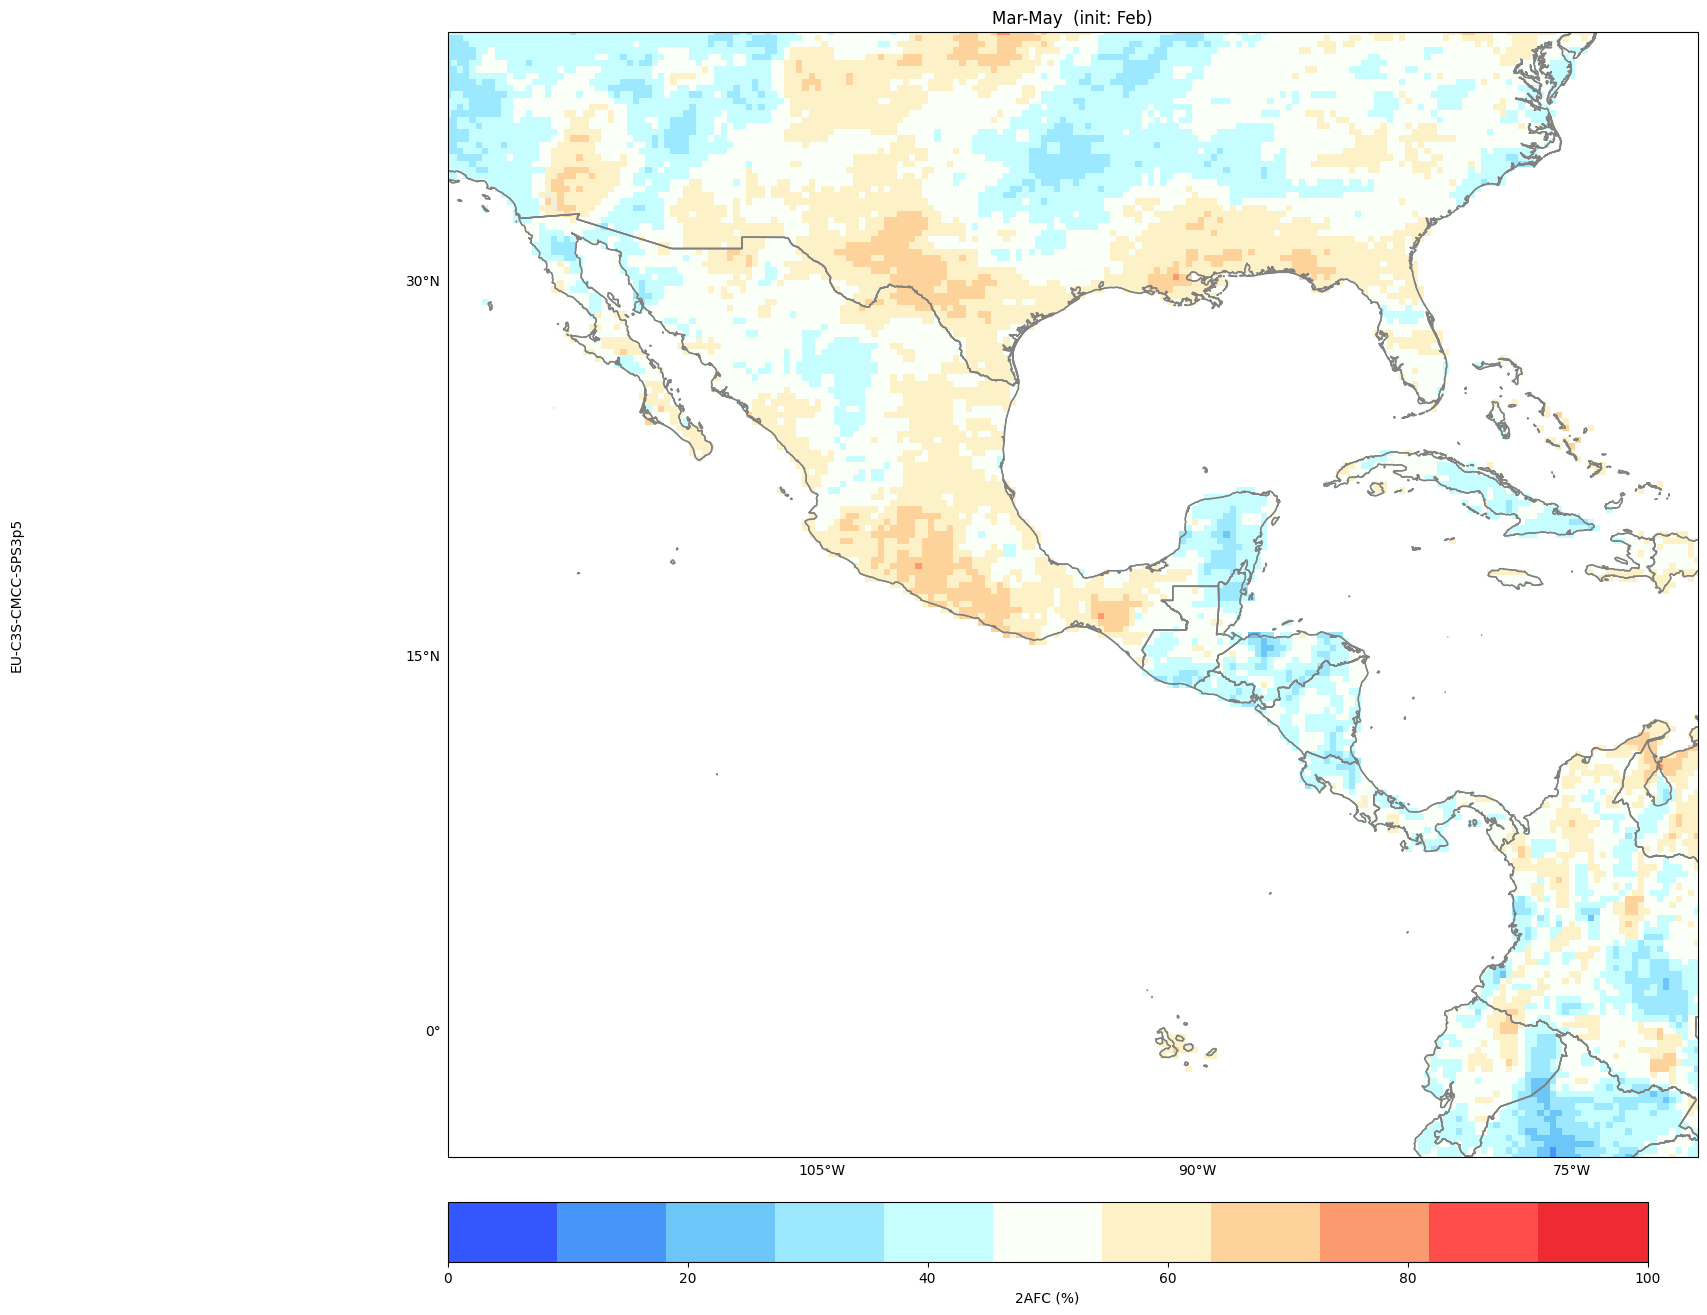



GROC


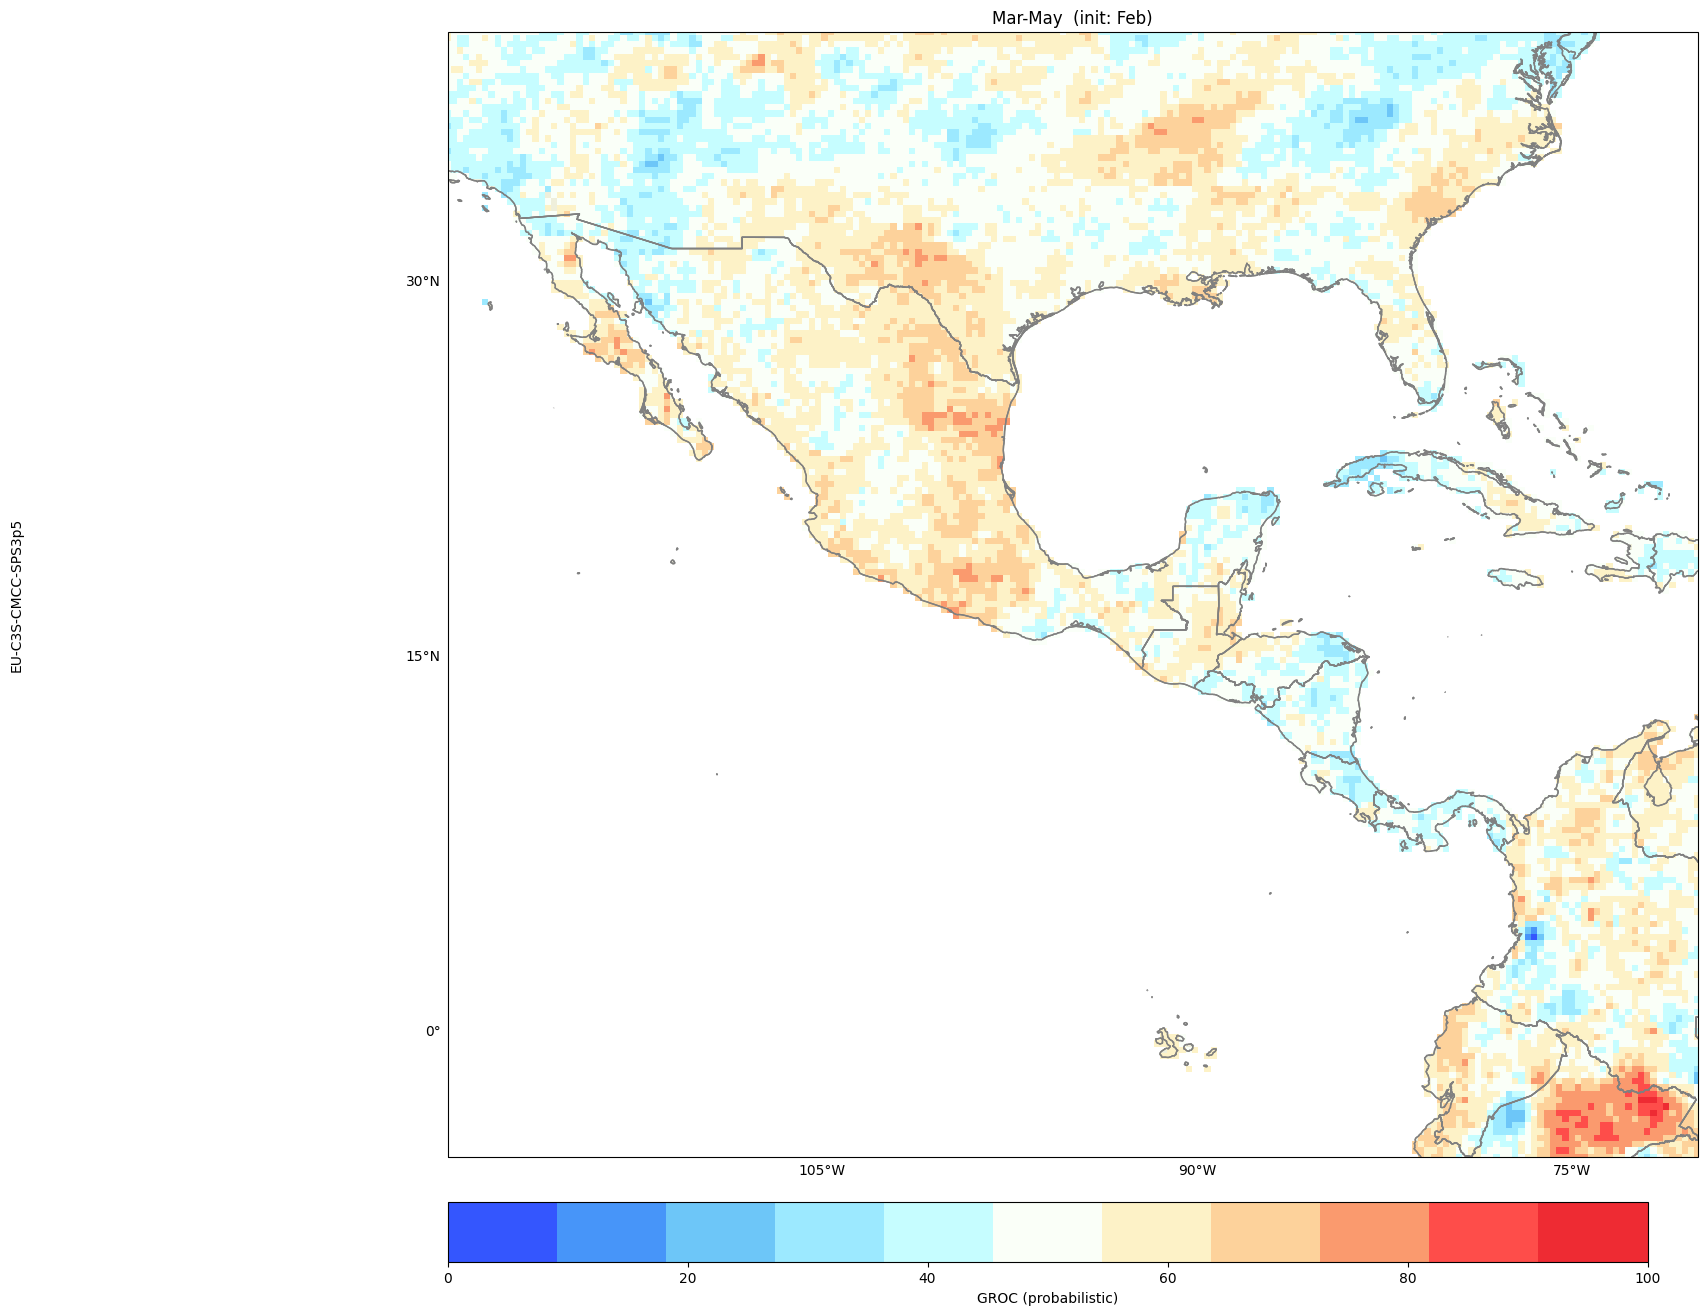

In [61]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow'):
#met=('Ignorance','RPSS','GROC')
met=('Pearson','Spearman','2AFC','GROC')
#monss=['Jul-Sep']   #Needs to be any of the seasons computed.#

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
for ime in met:
    pltmap(models,PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss,map_color, colorbar_option, use_ocean, x_offset=x_offset, y_offset=y_offset)   
    plt.savefig(('figures/Skill-Models-'+obs+'-'+MOS+'-' + ime + '.pdf'), dpi=300)
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    #plt.close()
    plt.show()
    print('')


# Single Model Probabilistic Forecasts
Author: Patric

Present folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023


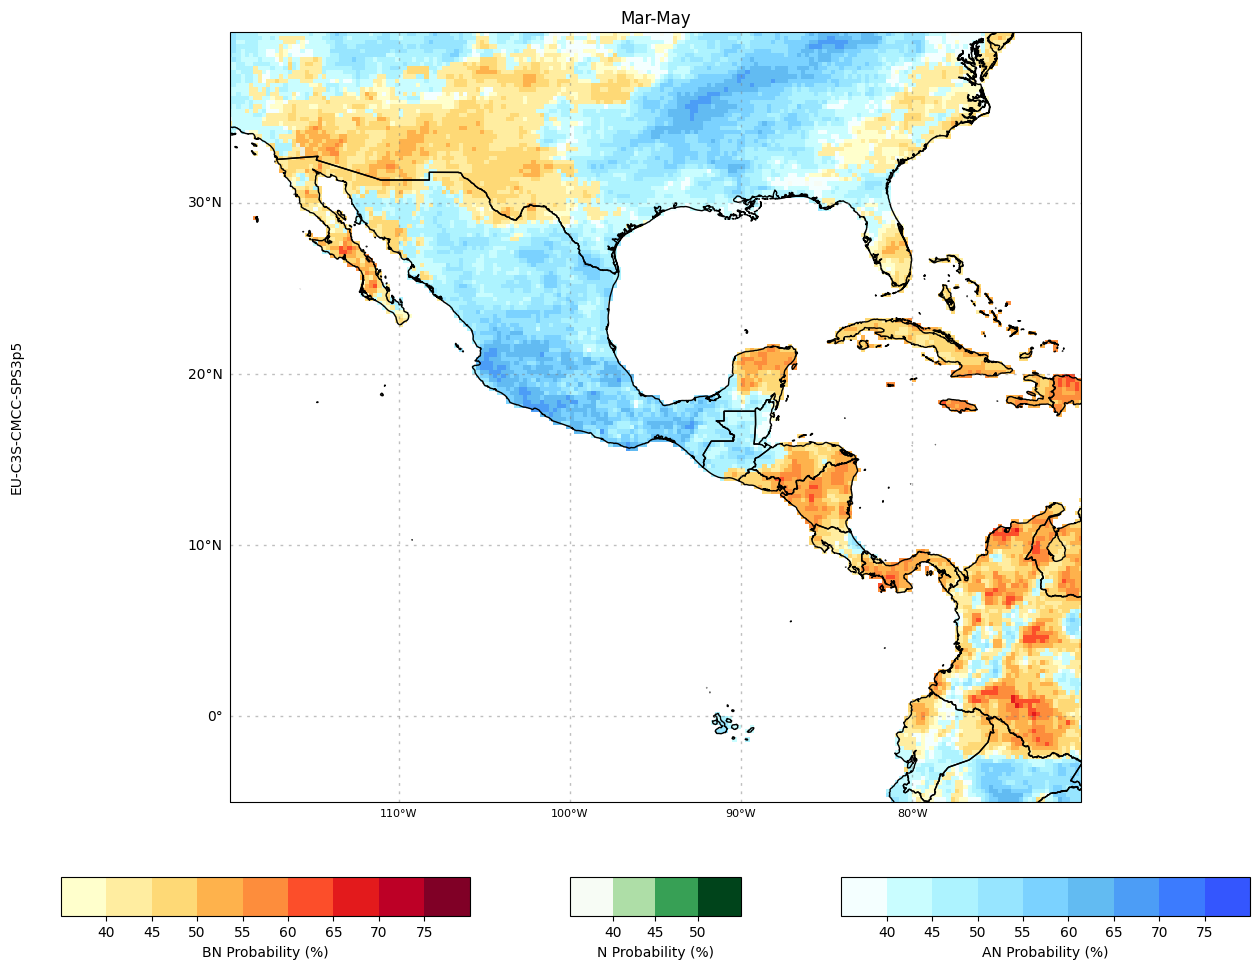

In [63]:
if single_models and MOS != 'None':
    print("Present folder:")
    %cd $workdir 
    plt_single_probabilistic(models,PREDICTOR,PREDICTAND,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mon, fyr, use_ocean)
elif single_models and MOS not in ['CCA', 'PCR']: 
    print('PROBABILISTIC FORECASTS ONLY AVAILABLE IF MOS=CCA or MOS=PCR')
elif MOS in ['CCA', 'PCR'] and not single_models: 
    print('SET single_models=True TO PLOT INDIVIDUAL GCM DETERMINISTIC FORECASTS')
else: 
    pass 

# Single Model Deterministic Forecast and Confidence Intervals
Author: Cuihua / Patric

Present folder:
/home/guillermo/DEV/EPS/iri-pycpt/EPS-PRCP_abr-jun2023


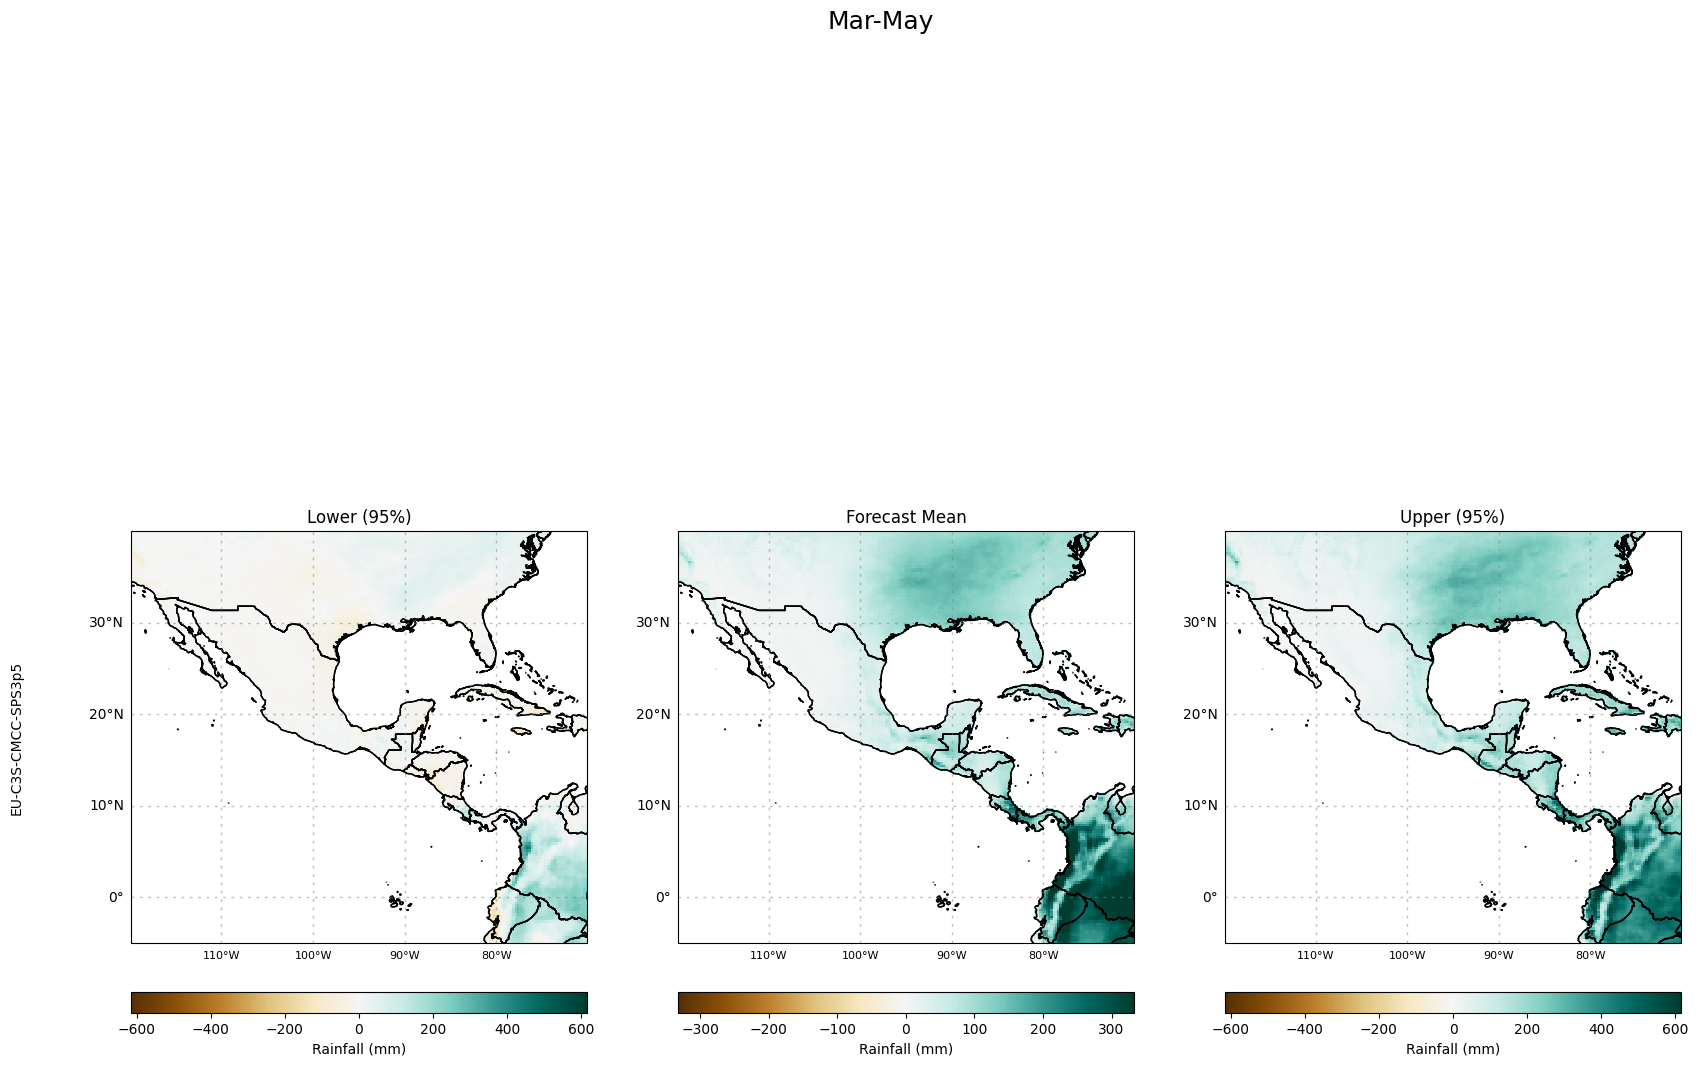

In [64]:
if single_models and MOS != 'None':
    print("Present folder:")
    %cd $workdir 
    plt_single_deterministic_and_confidenceIntervals(models,PREDICTOR,PREDICTAND,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mon, fyr, use_ocean, confidence_level, forecast_spi)
elif single_models and MOS not in ['CCA', 'PCR']: 
    print('FORECASTS ONLY AVAILABLE IF MOS=CCA or MOS=PCR')
elif MOS in ['CCA', 'PCR'] and not single_models: 
    print('SET single_models=True TO PLOT INDIVIDUAL GCM DETERMINISTIC FORECASTS')
else: 
    pass 

## Multi-model ensemble: NextGen

In [45]:
#Indicate models to be included in the NextGen ensemble:
#models=['EU-C3S-ECMWF-SEAS5','EU-C3S-MeteoFrance-System7','EU-C3S-UKMO-GloSea5GC2S15']



In [46]:
mon

'Feb'

In [47]:
MOS

'CCA'

In [48]:
print('\033[1m----Assessing skill for NextGen----\033[0;0m')
model='NextGen'
NEXTGEN_MOS='None'   #we're changing here to no MOS to assess skill of NextGen
print('Using the following model(s) in the NextGen cocktail: \n\n'+str(models))
print('')
print('')
print('')

for mo in range(len(mons)):
    mon=mons[mo]
    tar=tgts[mo]
    tgti=tgtii[mo]
    tgtf=tgtff[mo]
    print("New folder:")
    %cd $workdir/input

    print('Preparing CPT files for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization \033[1m'+mon+'\033[0;0m...')
    NGensemble(models,fprefix,PREDICTOR,PREDICTAND,mpref,'FCST_xvPr',tar,mon,tgti,tgtf,monf,fyr)
    
    print("New folder:")
    %cd $workdir/scripts

    #We run CPT with a NoMOS configuration, BUT producing a MOS=mpref (e.g., CCA) file!
    CPTscript(model,PREDICTAND, mon,monf, fyr, tini,tend,nla1,sla1,wlo1,elo1,nla2,sla2,wlo2,elo2,fprefix,mpref,tar,ntrain,NEXTGEN_MOS,station, xmodes_min, xmodes_max, ymodes_min, ymodes_max, ccamodes_min, ccamodes_max, forecast_anomaly, forecast_spi)

    print('Executing CPT for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization: \033[1m'+mon+'\033[0;0m...')
    try:
        subprocess.check_output(cptdir+'CPT.x < params > CPT_log_'+model+'_'+tar+'_'+mon+'.txt',stderr=subprocess.STDOUT, shell=True)
    except subprocess.CalledProcessError as e:
        print(e.output.decode())
        raise
    print('----------------------------------------------')
    print('Calculations completed for \033[1m'+tar+'\033[0;0m - Initialization: \033[1m'+mon+'\033[0;0m')
    print('See output folder, and check scripts/CPT_log_'+model+'_'+tar+'_'+mon+'.txt for errors')
    print('\033[1mQuick error report from CPT (if any):\033[0;0m')
    with open('CPT_log_'+model+'_'+tar+'_'+mon+'.txt', "r") as fp:
        for line in lines_that_contain("Error:", fp):
            print (line)
        print('----------------------------------------------')
        print('----------------------------------------------')
    print('Generating FlexForecast files for \033[1m'+model+'\033[0;0m. Target: \033[1m'+tar+'\033[0;0m - Initialization: \033[1m'+mon+'\033[0;0m...')
    NGensemble(models,fprefix,PREDICTOR,PREDICTAND,mpref,'FCST_mu',tar,mon,tgti,tgtf,monf,fyr)    
    NGensemble(models,fprefix,PREDICTOR,PREDICTAND,mpref,'FCST_var',tar,mon,tgti,tgtf,monf,fyr) 
    print('----------------------------------------------')

print('')
print('')
print('')
print('\033[1mPROCESS COMPLETED \033[0;0m')

----Assessing skill for NextGen----
Using the following model(s) in the NextGen cocktail: 

['COLA-RSMAS-CCSM4', 'NCEP-CFSv2', 'CanSIPS-IC3', 'GFDL-SPEAR']



New folder:
/home/lrtun/Documentos/CPT/PyCPTseav1.9.2/PRCP_mar-may_feb2022/input
Preparing CPT files for NextGen. Target: Mar-May - Initialization Feb...
Cross-validated prediction files successfully produced
New folder:
/home/lrtun/Documentos/CPT/PyCPTseav1.9.2/PRCP_mar-may_feb2022/scripts
Executing CPT for NextGen. Target: Mar-May - Initialization: Feb...
----------------------------------------------
Calculations completed for Mar-May - Initialization: Feb
See output folder, and check scripts/CPT_log_NextGen_Mar-May_Feb.txt for errors
Quick error report from CPT (if any):
----------------------------------------------
----------------------------------------------
Generating FlexForecast files for NextGen. Target: Mar-May - Initialization: Feb...
Wrote ../output/NextGen_PRCPPRCP_CCAFCST_mu_Mar-May_Feb2022.ctl
Wrote ../output/N

Present folder:
/home/lrtun/Documentos/CPT/PyCPTseav1.9.2/PRCP_mar-may_feb2022/output

Pearson


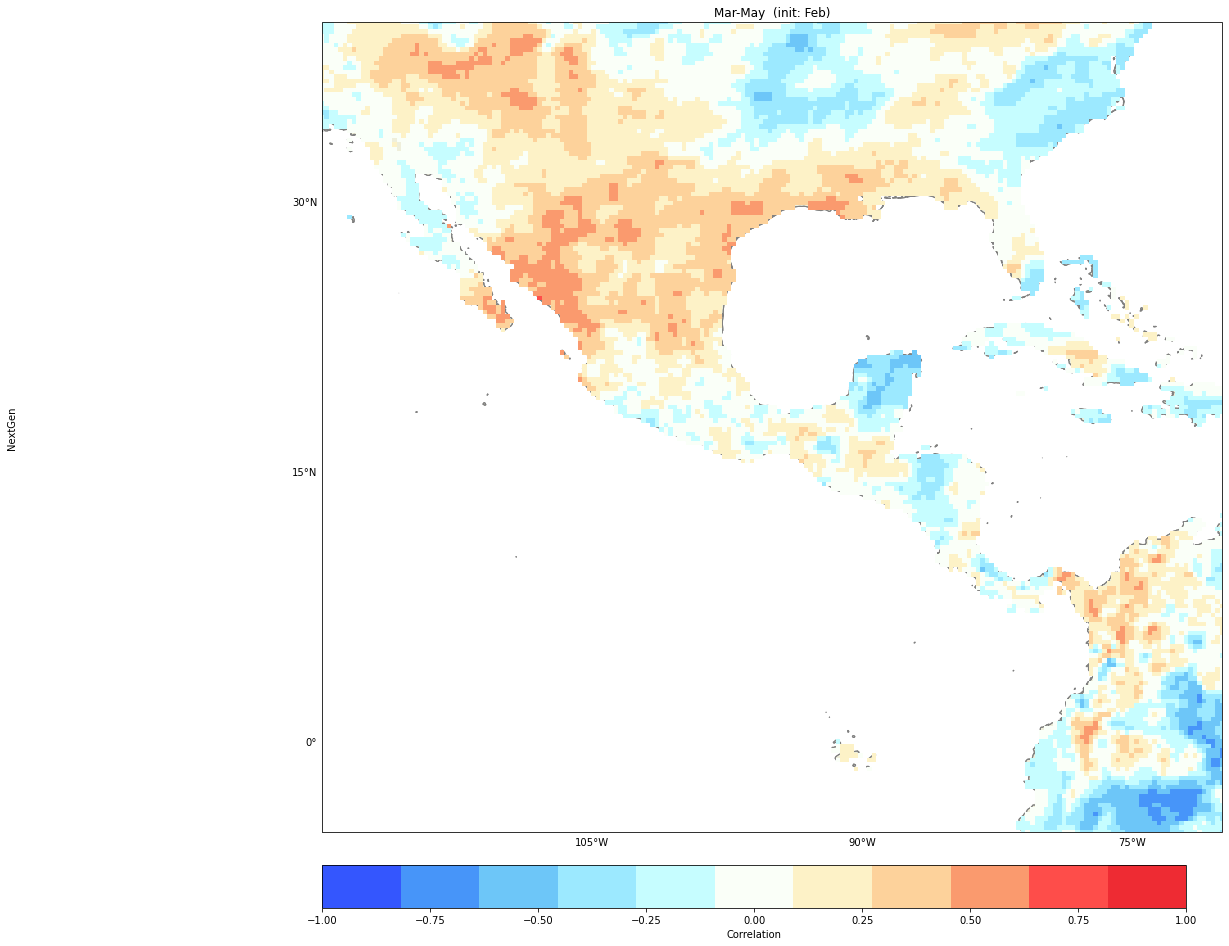



Spearman


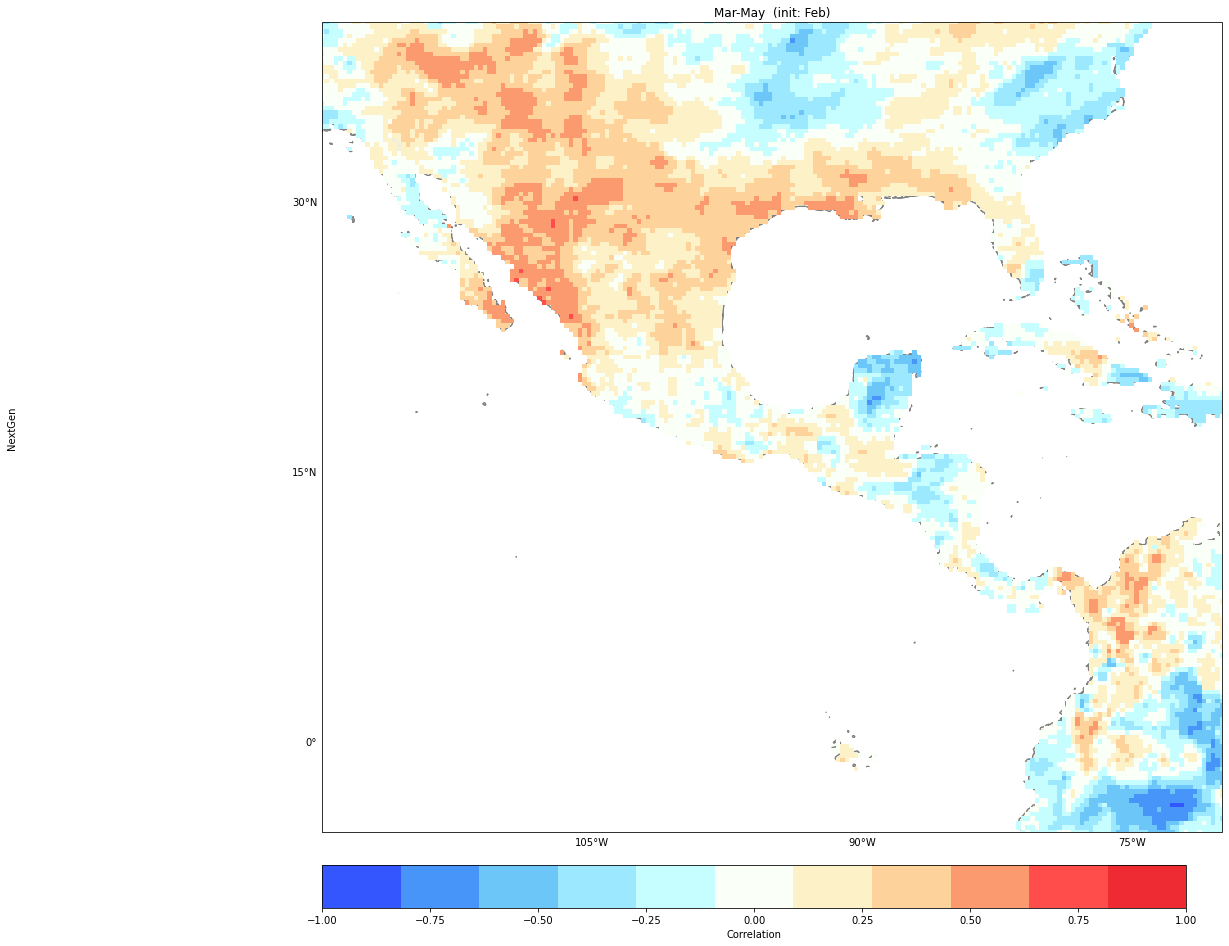



2AFC


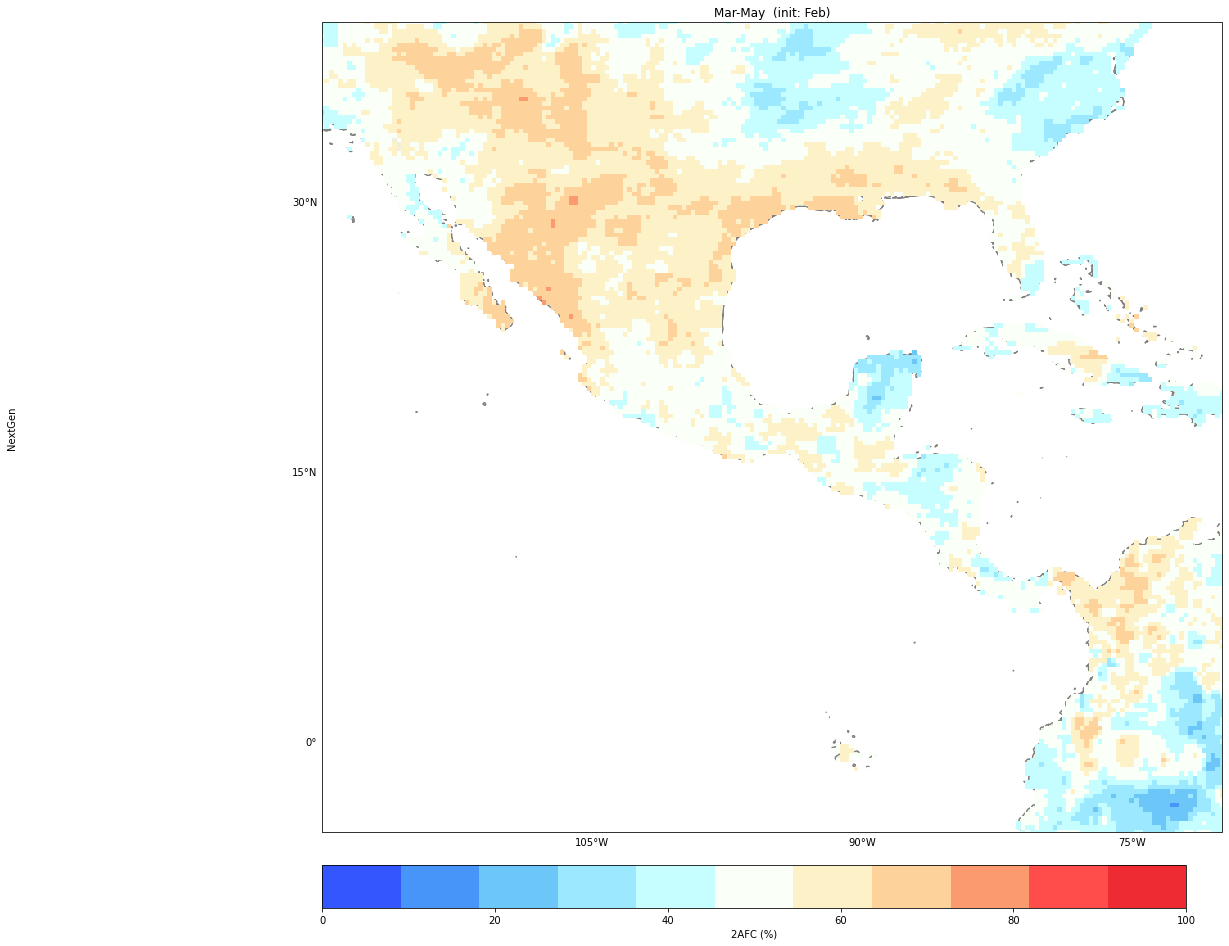



GROC


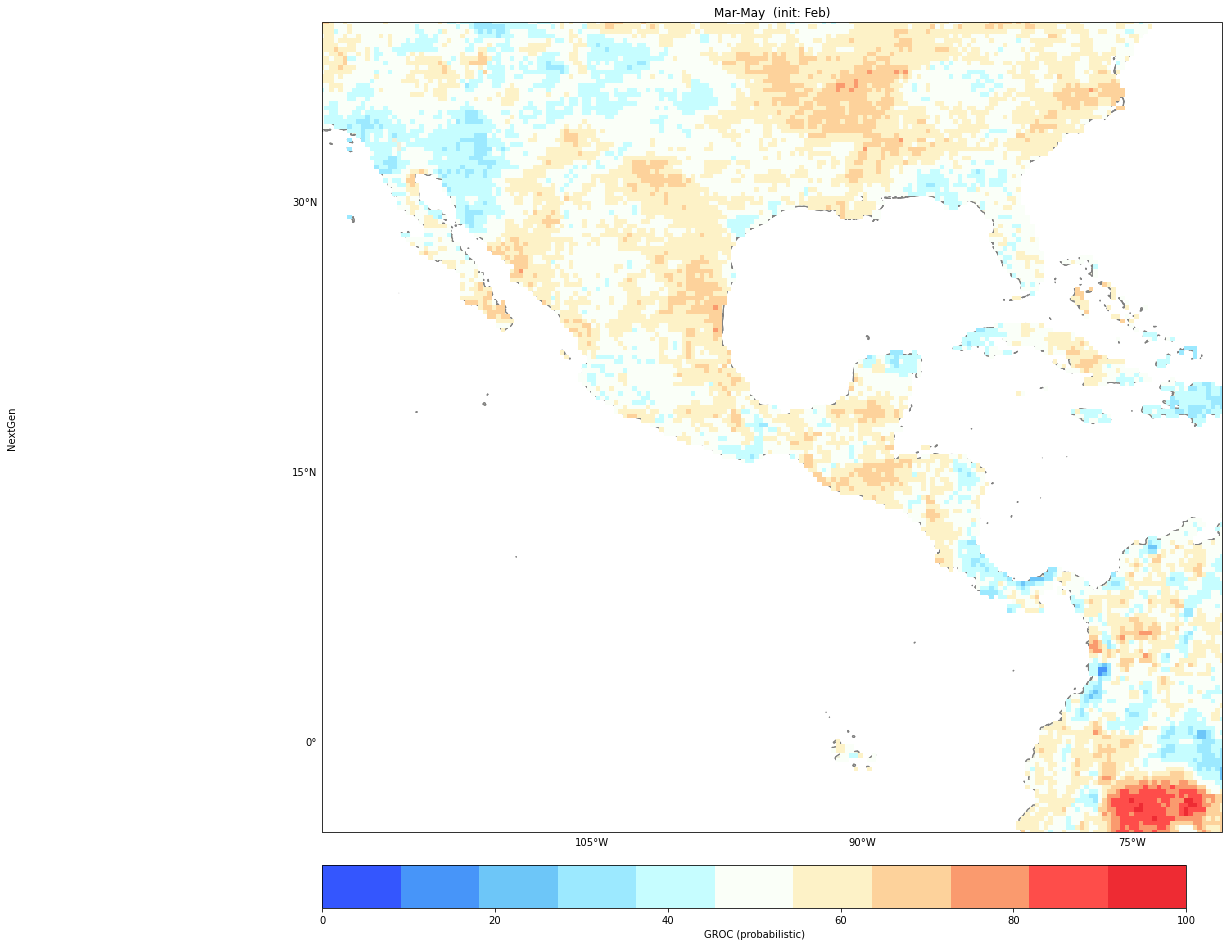

In [49]:
#####Choose metrics (options are: 'Pearson','Spearman','2AFC','RocAbove','RocBelow','Ignorance','RPSS','GROC'):
met=('Pearson','Spearman','2AFC','GROC')
#monss=['Jul-Sep']#Aug-Oct','Mar-May','Apr-Jun','Sep-Nov']   #Needs to be any of the seasons computed.

#models=['NextGen','CanSIPSv2', 'COLA-RSMAS-CCSM4', 'GFDL-CM2p5-FLOR-A06', 'GFDL-CM2p5-FLOR-B01', 'NASA-GEOSS2S', 'NCEP-CFSv2']

print("Present folder:")
%cd $workdir/output

# Skill scores loop
plt.rcParams.update({'font.size': 10})
for ime in met:
    pltmap(['NextGen'],PREDICTAND,ime,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts,mons,monss,map_color, colorbar_option, use_ocean, x_offset=x_offset, y_offset=y_offset)   
    plt.savefig(('figures/Skill-NextGen-'+obs+'-'+MOS+'-' + ime + '.pdf'), dpi=300)
    print('')
    print("\033[1m"+ime+"\033[0;0m")
    plt.show()
    print('')

Present folder:
/home/lrtun/Documentos/CPT/PyCPTseav1.9.2/PRCP_mar-may_feb2022


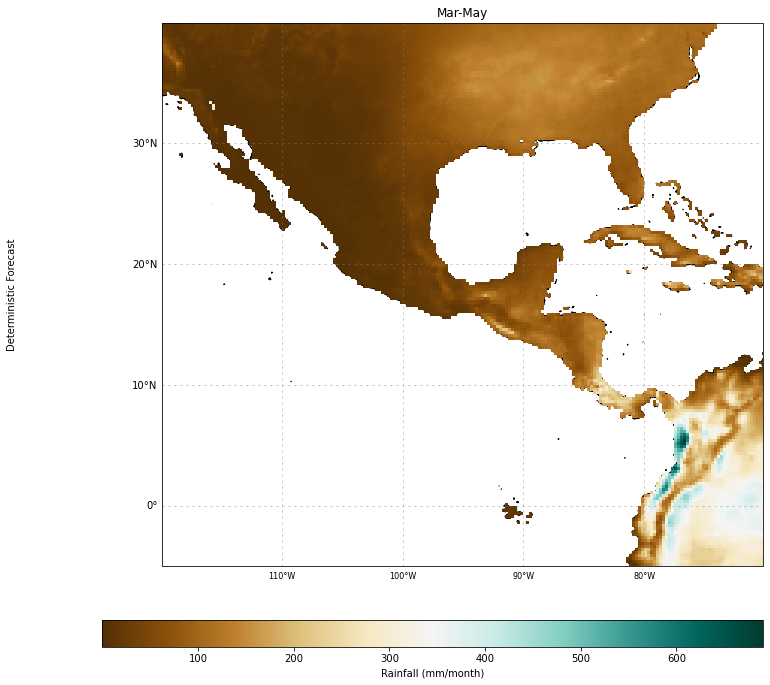

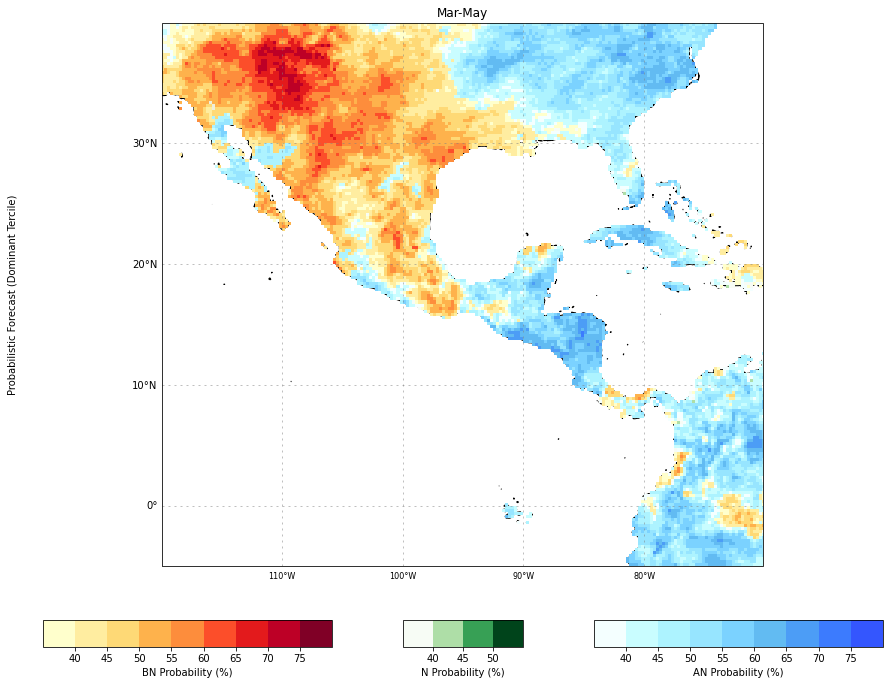

In [50]:
print("Present folder:")
%cd $workdir 
plt_ng_deterministic(models,PREDICTOR,PREDICTAND,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mon, fyr, use_ocean)
if MOS != "None":
    plt_ng_probabilistic(models,PREDICTOR,PREDICTAND,wlo2,elo2,sla2,nla2,fprefix,mpref,tgts, mon, fyr, use_ocean)
else: 
    print('Probababilistic Forecasts only available when MOS=CCA or MOS=PCR')


### Flexible Forecasts

Folder:
/home/lrtun/Documentos/CPT/PyCPTseav1.9.2/PRCP_mar-may_feb2022/output
Wrote ../output/NextGen_PRCPPRCP_CCAFCST_Obs_Mar-May_Feb2022.ctl
Wrote ../output/NextGen_PRCPPRCP_CCAFCST_Obs_Mar-May_Feb2022.dat
Skipping cpt:T line


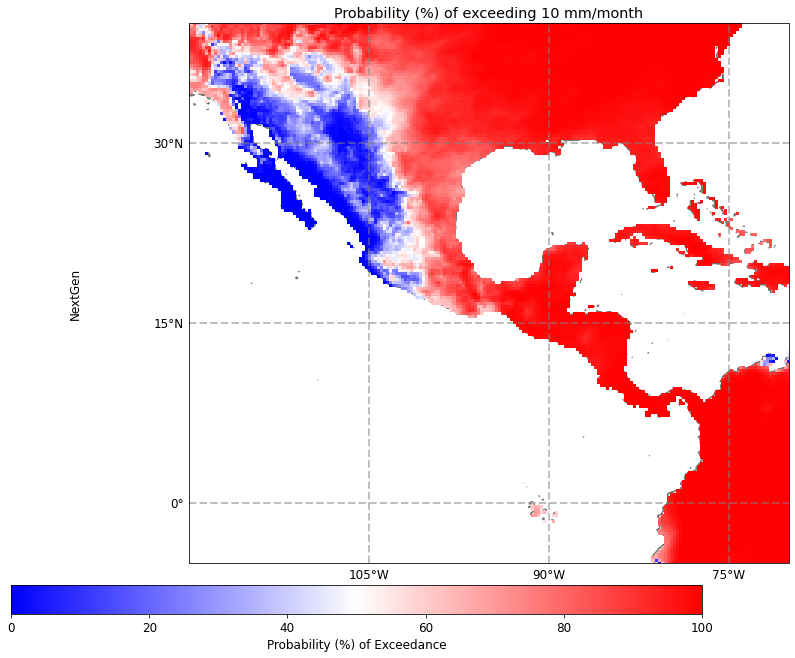

In [51]:
flexformat_threshold = 10 #threshold for the flexible format map --here is just a scalar (only one target season)
ffthres_ispctl=False  #If True, flex format threshold is a percentile: 0.001 - 0.999

print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltmapff(['NextGen'],PREDICTOR, PREDICTAND,flexformat_threshold,ffthres_ispctl,ntrain,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts,x_offset=x_offset, y_offset=y_offset)
plt.savefig("ProbFcst_Flex_JJA_ene2019.png", dpi=300)

#### For some reason, this plot sometimes appears very small - if so, please try double clicking it

Folder:
/home/lrtun/Documentos/CPT/PyCPTseav1.9.2/PRCP_mar-may_feb2022/output
Skipping cpt:T line
PROBLEM: OBS SHAPE (180, 200) BUT FCST SHAPE (180, 200)


<Figure size 1080x1080 with 0 Axes>

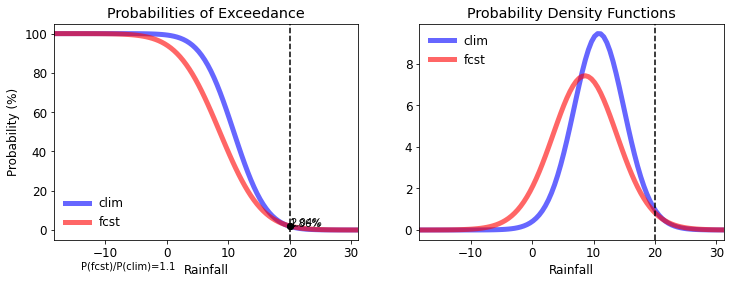

In [52]:
flexformat_threshold = 20 #threshold for the flexible format map --here is just a scalar (only one target season)
ffthres_ispctl=False  #If True, flex format threshold is a percentile: 0.001 - 0.999
lon=-102.0
lat=24#24
 
print("Folder:")
%cd $workdir/output
plt.rcParams.update({'font.size': 12})
pltprobff(['NextGen'],PREDICTOR, PREDICTAND,flexformat_threshold,ntrain,lon,lat,wlo2,elo2,sla2,nla2,fprefix,mpref,monf,fyr,mons,tgts)
plt.savefig("ProbExceed.pdf", dpi=300)

## Saving Jupyter Notebooks following the naming convention (optional)
Author: Patric

In [53]:
destination = '/mnt/c/Users/Patri/OneDrive/Columbia_Academics/S2S/iri-pycpt/pycpt_senegal/'  # user-definable saving location for the current .ipynb

# uncomment below to use this save notebook function
from calendar import month_abbr
#save_notebook_with_naming_convention(savedir,destination,mons,month_abbr,tgtii, nla1,sla1,nla2,sla2,wlo1,elo1,wlo2,elo2,PREDICTAND,obs,PREDICTOR,models,fyr)